<a href="https://colab.research.google.com/github/zeyneplacin/BrainMRI/blob/main/Uygulamal%C4%B1_Yapay_Zeka__v0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kütüphaneler

In [66]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from google.colab import drive
from torch import nn
from torchsummary import summary
from time import time
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from torch.nn.functional import softmax

Google Drive bağlantısını sağlıyor.

In [ ]:
drive.mount('/content/drive')


Drive'daki verilerin adresi

In [3]:
data_path = './drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/2020 dataset_pre processed/Gazi_BRAIN_2020_Dataset'
tumor_path = data_path + '/Tumor'
normal_path = data_path + '/Normal'

Test:
Drive'daki dosyaları görebiliyor mu?

In [ ]:
os.listdir(data_path)


Test:
Tümör ve Normal olan dosyaların uzantılarını görebiliyor mu?

In [ ]:
os.listdir(tumor_path)
os.listdir(normal_path)

## veri setini oluşturma. yukarıda alınan pathlerden veri seti hazırlanıyor. Her iki sınıftaki veriler bir araya getiriliyor.

In [6]:
from genericpath import isfile
class BrainDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        #store filenames
        labls = os.listdir(data_dir)
        print (labls) #data_dir altindaki dizin isimleri
        self.labelnames = [] # data_dir içerisindeki etiket listesi, distinct olarak tutuluyor.


        self.filenames = [] #bulunan her bir görüntünün adresi tutuluyor örn: './drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/2020 dataset_pre processed/Gazi_BRAIN_2020_Dataset/Tumor/img226.jpg'

        for f in labls:
          basedir = os.path.join(data_dir, f) #basedir = data_dir ve alt dizinin birlesmis hali
          if os.path.isfile(basedir):
            pass #readme.txt okunmadan atlanıyor.
          else:
            self.labelnames.append(f)
            print ("basedir=", basedir)
            images = os.listdir(basedir) #basedir altindaki resimlerin listesi
            print (images)
            fnames = [os.path.join(basedir, im) for im in images] #resimlerin tam dizinli dosya ismi
            self.filenames.extend(fnames) ###################################3 BURADA NE YAPILIYOR?
            print('dosya isimleri: ', self.filenames)
            print ('dosya sayısı: ', len(self.filenames))

        print('etiketler: ', self.labelnames)
        #etiketler dosya isminden aliniyor
        self.labels = [filename.split('/')[-2] for filename in self.filenames] #bulunan her bir görüntünün sırasıyla etiketlerini tutuyor.   ########## NEDEN -2?
        print ("labels:", self.labels)
        self.transform = transform

    def __len__(self):
        #goruntu listesinin boyutunu dondurur
        return len(self.filenames)

    def numberOfSamples(self):
      a= self.__len__()
      print(type(a))
      return a

    def __getitem__(self, idx):
        #goruntu aciliyor, donusum uygulaniyor ve etiketiyle birlikte donduruluyor
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        label = self.name_to_idx(self.labels[idx])

        #print ('image', type(image))
        #print ('label', type(label))
        return image, label
    def name_to_idx(self, lblname):
        return self.labelnames.index(lblname)
    def idx_to_name(self, lblidx):
        return self.labelnames[lblidx]

pytorchlar tensorlarla çalıştığı için görüntüyü tensora çevirmek gerekiyor. Bu iki satır görüntüyü tensora çeviriyor.
Veriseti sınıfında init içinde veriliyor, getitem transform sırasında kullanıyor.

In [7]:
t2img = torchvision.transforms.ToPILImage()
img2t = torchvision.transforms.ToTensor()

oluşturduğumuz veriseti sınıfına Drive'dan aldığımız adresini gönderiyoruz, bir de görüntülere uygulanacak dönüşümleri gönderiyoruz. Verisetine yapılan pre process adımları burada yapılarak gönderiliyor.

Buradaki pre process adımları yerine doğrudan  transform=ToTensor() da kullanılabilir. Bu kullanılırken ayrıca
**img2t = torchvision.transforms.ToTensor()**
adımlarına gerek kalmayacaktı.

veri setini test ve train olarak ayırmak için **torch.utils.data.random_split(brain_dataset, [0.6, 0.2, 0.2])** kullanılıyor. 0.6, 0.2 oransal olarak verisetinin ne kadarının bölüneceğini gösteriyor. Bu durumda verisetinin %60'ı trainset olarak kullanılıyor.

ref:
https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

In [8]:
brain_dataset = BrainDataset(data_path, transform=torchvision.transforms.Compose([
          # torchvision.transforms.RandomHorizontalFlip(p=0.5),
          # torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
          # torchvision.transforms.RandomAffine(degrees=30, shear=10),
          # Resize image and normalize pixels using the provided mean and standard deviation
          # torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
          torchvision.transforms.Resize((256, 256)),
          img2t,
        ]))
print('verisetindeki veri sayısı: ', brain_dataset.numberOfSamples())

#train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(brain_dataset, [0.6, 0.2, 0.2])
train_dataset, test_dataset = torch.utils.data.random_split(brain_dataset, [0.7, 0.3])
print('train setindeki veri sayısı: ', len(train_dataset))
print('test setindeki veri sayısı: ', len(test_dataset))
#print('val setindeki veri sayısı: ', len(val_dataset))

['readme.txt', 'Tumor', 'Normal']
basedir= ./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/2020 dataset_pre processed/Gazi_BRAIN_2020_Dataset/Tumor
['img226.jpg', 'img70.jpg', 'img4.jpg', 'img144.jpg', 'img84.jpg', 'img348.jpg', 'img35.jpg', 'img346.jpg', 'img135.jpg', 'img18.jpg', 'img134.jpg', 'img97.jpg', 'img406.jpg', 'img394.jpg', 'img200.jpg', 'img231.jpg', 'img330.jpg', 'img87.jpg', 'img0.jpg', 'img137.jpg', 'img391.jpg', 'img192.jpg', 'img297.jpg', 'img186.jpg', 'img25.jpg', 'img311.jpg', 'img333.jpg', 'img187.jpg', 'img207.jpg', 'img235.jpg', 'img204.jpg', 'img259.jpg', 'img100.jpg', 'img267.jpg', 'img131.jpg', 'img156.jpg', 'img195.jpg', 'img95.jpg', 'img141.jpg', 'img92.jpg', 'img193.jpg', 'img266.jpg', 'img105.jpg', 'img171.jpg', 'img400.jpg', 'img19.jpg', 'img396.jpg', 'img63.jpg', 'img125.jpg', 'img323.jpg', 'img24.jpg', 'img281.jpg', 'img81.jpg', 'img107.jpg', 'img13.jpg', 'img289.jpg', 'img284.jpg', 'img28.jpg', 'img293.jpg', 'img27.jpg', 'img6.jpg', 'img379.jpg

Test
Görüntüler gerçekten okundu mu?

In [ ]:
def display_image_grid(images, images_per_row=8):
    if isinstance(images, torch.Tensor):
        images = images.split(1, dim=0)
        images = map(lambda x: x.squeeze(0), images)
        images = list(map(t2img, images))
    elif isinstance(images, list):
        # Expect a list of PIL Images
        if isinstance(images[0], torch.Tensor):
            images = list(map(t2img, images))
        # end if
    elif isinstance(images, Image):
        images = [images]
    else:
        raise RuntimeError(f"Hata: {type(images)}")
    # end if

    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig = plt.figure(figsize=(images_per_row * 2, num_rows * 3))

    for i in range(1, num_images + 1):
        plt.subplot(num_rows, images_per_row, i)
        plt.axis("off")
        plt.imshow(images[i-1])
    # end for

    plt.show()

display_image_grid([
    train_dataset[0][0],
    train_dataset[21][0],
    train_dataset[16][0],
    train_dataset[130][0],
    train_dataset[260][0],
    train_dataset[73][0],
    train_dataset[148][0],
    train_dataset[256][0],
], 6)



Data Loader
Veri setini alıyor ve modele gönderiyor. Test ve Train olarak oluşturuyoruz.

Görüntüler gerçekten alındı mı diye test de ediliyor.

Data Loader yaratılırken Batch Size ve shuffle kullanıyor. Batch size kaç verildiyse her iterasyonda o kadar görüntü ve onların sınıfları alınıyor.


Sınıf 0: Tümör
Sınıf 1: Normal

os.listdir(data_path) adımındaki sıralamaya göre indeksleniyor.

In [ ]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=12,
  shuffle=True,
)

inputs, targets = next(iter(train_loader))
display_image_grid(inputs, images_per_row=4)
print (targets)

In [ ]:
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=12,
  shuffle=False,
)

inputs, targets = next(iter(test_loader))
display_image_grid(inputs, images_per_row=4)
print (targets)

# **Model Yaratma**

summary(model, (3,256,256),9)

rgb kanal sayısı: 3
girdi boyutu: 256 x 256
batch size: 9



nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),

**Layer (type)    Output Shape               Param #**
Conv2d-1        [9, 16, 254, 254]             448
ReLU-2          [9, 16, 254, 254]               0
Conv2d-3        [9, 16, 252, 252]           2,320

batch size 9 olduğu için output shape 9 ile başlıyor.
16 tane çıktı kanalı var (conv2d-1 için).
kernel size 3 olduğu için 256 x 256'lık görüntüden 2 satır 2 sütun çıkaracak şekilde 254 x 254 'lük görüntü oluşuyor.
Conv2d-2 için yine batch size 9 olduğundan 9 ile başlıyor. 16 tane output kanalı var ve 254 x 254 'lük görüntüden 252 x 252'lik görüntü oluşturuyor. (kernel nedeniyle)

conv2d-1 için parametre sayısı: 3 girdi kanalı * 16 çıktı kanalı * kernel boyutu (3*3=9) + her çıktı kanalı için 1 bias (1*16) = 448

conv2d-2 için parametre sayısı: 16 girdi kanalı * 16 çıktı kanalı * kernel boyutu (3*3=9) + her çıktı kanalı için 1 bias (1*16) = 2320

**Layer (type)             Output Shape            Param #**
MaxPool2d-25             [9, 256, 4, 4]          0
Flatten-26               [9, 4096]               0
Dropout-27               [9, 4096]               0

Flatten: batch size, 256 çıktı kanalı * 4 x 4'lük görüntünün piksel sayısı (4*4 = 16) = 4096 => 9, 4096
tüm pikselleri tek bir satıra diziyor.
Dropout: dizilen piksellerden bazılarını random olarak 0 yapıyor ve parametre olarak gönderilen p olasılık değerini 1/(1-p) formülüyle diğer piksellerin  değerlerini çarpıyor.
Bazı pikseller 0 olsa bile boyut değiştirme olmadığı için boyut: 9, 4096

(ref: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

class MRIClassifier(nn.Module):
    def __init__(self):
        super(MRIClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 10)
        ).to(device)

    def forward(self, x):
        #print('x boyutu: ', x.shape)
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MRIClassifier().to(device)
summary(model, (1,256,256),16)

In [13]:
lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Başarım Ölçütlerinin Hesaplaması

In [54]:
def Accuracy(target, predicted):
    true_positive = (target == predicted).sum().item()
    accuracy = true_positive / target.size(0)
    #print('TP in Accuracy: ', true_positive)   #####Test
    return accuracy

def Precision(target, predicted):
    true_positive = ((target == 1) & (predicted == 1)).sum().item()
    false_positive = ((target == 0) & (predicted == 1)).sum().item()
    #print('TP: ', true_positive, 'FP: ', false_positive)     #####Test

    if true_positive + false_positive == 0:
        return 0  # To avoid division by zero

    precision = true_positive / (true_positive + false_positive)
    return precision

def Recall(target, predicted):
    true_positive = ((target == 1) & (predicted == 1)).sum().item()
    false_negative = ((target == 1) & (predicted == 0)).sum().item()

    if true_positive + false_negative == 0:
        return 0  # To avoid division by zero

    recall = true_positive / (true_positive + false_negative)
    return recall

def F1_Score(target, predicted):
    precision = Precision(target, predicted)
    recall = Recall(target, predicted)

    if precision + recall == 0:
        return 0  # To avoid division by zero

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

ROC/AUC Eğrilerinin Oluşturulması

In [67]:
def Predict(model, data_loader):
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in data_loader:
            minput = batch[0].to(device)
            target = batch[1].to(device)
            moutput = model(minput)
            probabilities = softmax(moutput, dim=1)  # Olasılık skorlarını hesapla
            predictions.extend(probabilities.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(predictions), np.array(targets)

def Plot_ROC_AUC(model, test_loader):
    predictions, targets = Predict(model, test_loader)
    fpr, tpr, thresholds = roc_curve(targets, predictions[:, 1])  # Olasılık skorlarını kullan
    auc_score = roc_auc_score(targets, predictions[:, 1])  # Olasılık skorlarını kullan

    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

Train ve Test https://medium.com/swlh/deep-learning-for-image-classification-creating-cnn-from-scratch-using-pytorch-d9eeb7039c12 ,den geldi.

In [55]:
def Train(epoch, print_every=10):
    total_loss = 0
    start_time = time()

    accuracy = []
    precision = []
    recall = []
    f1_score = []

    for i, batch in enumerate(train_loader, 1):
        #print('batch-0: ', batch[0])
        #print('batch-1: ', batch[1])
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas

        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model

#Accuracy Hesaplama
        #accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor
        #print(target, argmax, target.shape[0])     #####Test
        accuracy.append(Accuracy(target, argmax))


#Precision Hesaplama
        precision.append(Precision(target, argmax))

#Recall Hesaplama
        recall.append(Recall(target, argmax))

#F1-Skor Hesaplama
        f1_score.append(F1_Score(target, argmax))


        if i%print_every == 0:
            avg_accuracy = sum(accuracy) / len(accuracy) if accuracy else 0
            avg_precision = sum(precision) / len(precision) if precision else 0
            avg_recall = sum(recall) / len(recall) if recall else 0
            avg_f1_score = sum(f1_score) / len(f1_score) if f1_score else 0

            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Average Train Accuracy: {:.2f}, Average Train Precision: {:.2f}, Average Train Recall: {:.2f}, Average Train F1 Score: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_loader), loss.item(), avg_accuracy, avg_precision, avg_recall, avg_f1_score, time()-start_time
            ))
            f.write('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Average Train Accuracy: {:.2f}, Average Train Precision: {:.2f}, Average Train Recall: {:.2f}, Average Train F1 Score: {:.2f}, Time: {:.2f} sec\n'.format(
                epoch, i, len(train_loader), loss.item(), avg_accuracy, avg_precision, avg_recall, avg_f1_score, time()-start_time
            ))



    return total_loss / len(train_loader) # Returning Average Training Loss

In [ ]:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Average Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_loader), loss.item(), avg_accuracy, time()-start_time
            ))
            f.write('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Average Accuracy: {:.2f}, Time: {:.2f} sec\n'.format(
                epoch, i, len(train_loader), loss.item(), avg_accuracy, time()-start_time
            ))

In [64]:
def Test(epoch):
    total_loss = 0
    start_time = time()
    global best_acc, best_precision, best_recall, best_f1_score
    print ('Testing')
    #print ('best acc = ', best_acc)
    #print ('best precision = ', best_precision)
    #print ('best recall = ', best_recall)
    accuracy = []
    precision = []
    recall = []
    f1_score = []

    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_loader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()


            # To get the probabilities for different classes we need to apply a softmax operation on moutput
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)

#Accuracy Hesaplama
            #print(target, argmax, target.shape[0])  #####Test

            #current_acc = (target==argmax).sum().item() / target.shape[0]
            #accuracy.append(current_acc) # Find the accuracy of the batch by comparing it with actual targets

            current_acc = Accuracy(target, argmax)
            accuracy.append(current_acc)

            if current_acc > best_acc:
              best_acc = current_acc
              print ('* best acc = ', best_acc)

#Precision Hesaplama
            current_precision = Precision(target, argmax)
            precision.append(current_precision)

            if current_precision > best_precision:
                best_precision = current_precision
                print ('* best precision = ', best_precision)

#Recall Hesaplama
            current_recall = Recall(target, argmax)
            recall.append(current_recall)

            if current_recall > best_recall:
                best_recall = current_recall
                print ('* best recall = ', best_recall)

#F1-Skor Hesaplama
            current_f1_score = F1_Score(target, argmax)
            f1_score.append(current_f1_score)

            if current_f1_score > best_f1_score:
                best_f1_score = current_f1_score
                print ('* best f1_score = ', best_f1_score)

    avg_accuracy = sum(accuracy) / len(accuracy) if accuracy else 0
    avg_precision = sum(precision) / len(precision) if precision else 0
    avg_recall = sum(recall) / len(recall) if recall else 0
    avg_f1_score = sum(f1_score) / len(f1_score) if f1_score else 0

    print('Epoch: [{}], Test Loss: {:.4f}, Average Test Accuracy: {:.2f}, Average Test Precision: {:.2f}, Average Test Recall: {:.2f}, Average Test F1 Score: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_loader), avg_accuracy, avg_precision, avg_recall, avg_f1_score, time()-start_time
    ))

#ROC/AUC Eğrisini Gösterme
    Plot_ROC_AUC(model, test_loader)

    f.write('Epoch: [{}], Test Loss: {:.4f}, Average Test Accuracy: {:.2f}, Average Test Precision: {:.2f}, Average Test Recall: {:.2f}, Average Test F1 Score: {:.2f}, Time: {:.2f} sec, Best acc: {:.2f}, Best precision: {:.2f}\n'.format(
        epoch, total_loss/len(test_loader), avg_accuracy, avg_precision, avg_recall, avg_f1_score, time()-start_time, best_acc, best_precision
    ))
    return total_loss/len(test_loader) # Returning Average Testing Loss

Epoch  1
Epoch: [1]/(10/26), Train Loss: 0.7473, Average Train Accuracy: 0.59, Average Train Precision: 0.10, Average Train Recall: 0.03, Average Train F1 Score: 0.04, Time: 22.12 sec
Epoch: [1]/(20/26), Train Loss: 0.6897, Average Train Accuracy: 0.57, Average Train Precision: 0.05, Average Train Recall: 0.01, Average Train F1 Score: 0.02, Time: 44.38 sec
Testing
* best acc =  0.3333333333333333
* best acc =  0.6666666666666666
* best precision =  1.0
* best recall =  0.16666666666666666
* best f1_score =  0.2857142857142857
* best recall =  0.2
* best f1_score =  0.33333333333333337
* best acc =  0.75
Epoch: [1], Test Loss: 0.6831, Average Test Accuracy: 0.56, Average Test Precision: 0.18, Average Test Recall: 0.03, Average Test F1 Score: 0.06, Time: 11.89 sec


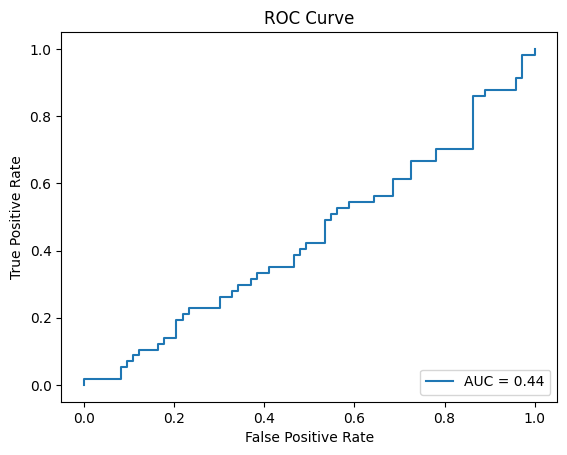

Epoch  2
Epoch: [2]/(10/26), Train Loss: 0.6932, Average Train Accuracy: 0.68, Average Train Precision: 0.10, Average Train Recall: 0.03, Average Train F1 Score: 0.04, Time: 21.09 sec
Epoch: [2]/(20/26), Train Loss: 0.6696, Average Train Accuracy: 0.61, Average Train Precision: 0.05, Average Train Recall: 0.01, Average Train F1 Score: 0.02, Time: 45.48 sec
Testing
Epoch: [2], Test Loss: 0.6936, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.65 sec


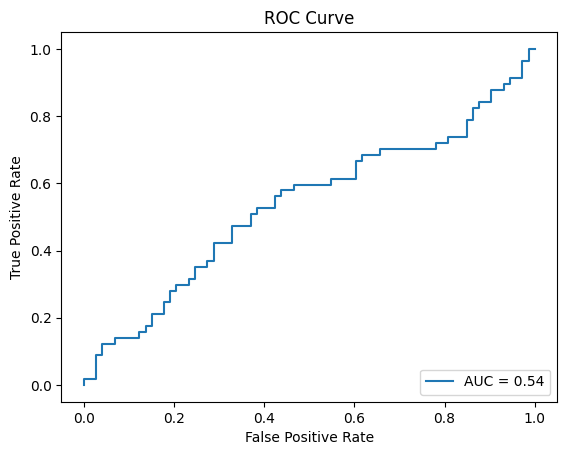

Epoch  3
Epoch: [3]/(10/26), Train Loss: 0.6900, Average Train Accuracy: 0.57, Average Train Precision: 0.10, Average Train Recall: 0.05, Average Train F1 Score: 0.07, Time: 22.67 sec
Epoch: [3]/(20/26), Train Loss: 0.6949, Average Train Accuracy: 0.58, Average Train Precision: 0.12, Average Train Recall: 0.07, Average Train F1 Score: 0.09, Time: 44.49 sec
Testing
* best acc =  0.8333333333333334
* best recall =  0.3333333333333333
* best f1_score =  0.5
Epoch: [3], Test Loss: 0.6995, Average Test Accuracy: 0.54, Average Test Precision: 0.18, Average Test Recall: 0.05, Average Test F1 Score: 0.07, Time: 9.97 sec


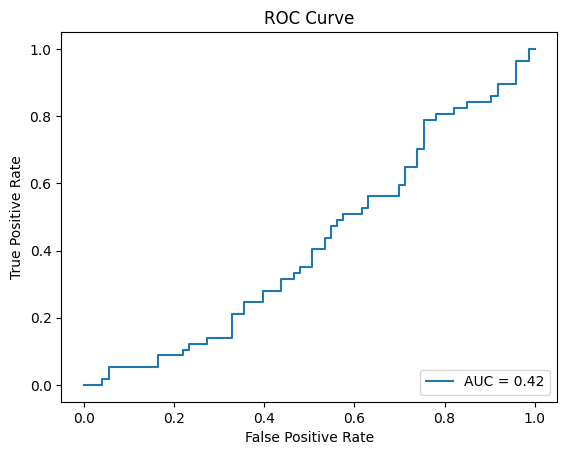

Epoch  4
Epoch: [4]/(10/26), Train Loss: 0.7003, Average Train Accuracy: 0.58, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 20.29 sec
Epoch: [4]/(20/26), Train Loss: 0.7154, Average Train Accuracy: 0.56, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 43.20 sec
Testing
Epoch: [4], Test Loss: 0.6832, Average Test Accuracy: 0.57, Average Test Precision: 0.09, Average Test Recall: 0.02, Average Test F1 Score: 0.03, Time: 8.63 sec


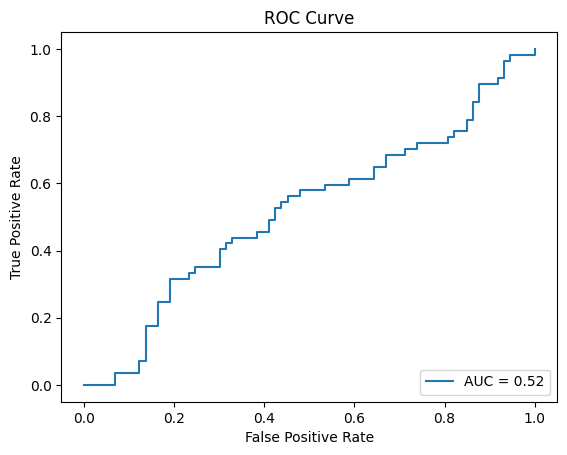

Epoch  5
Epoch: [5]/(10/26), Train Loss: 0.6888, Average Train Accuracy: 0.61, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 22.95 sec
Epoch: [5]/(20/26), Train Loss: 0.5894, Average Train Accuracy: 0.60, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 44.05 sec
Testing
Epoch: [5], Test Loss: 0.6934, Average Test Accuracy: 0.56, Average Test Precision: 0.09, Average Test Recall: 0.02, Average Test F1 Score: 0.03, Time: 9.97 sec


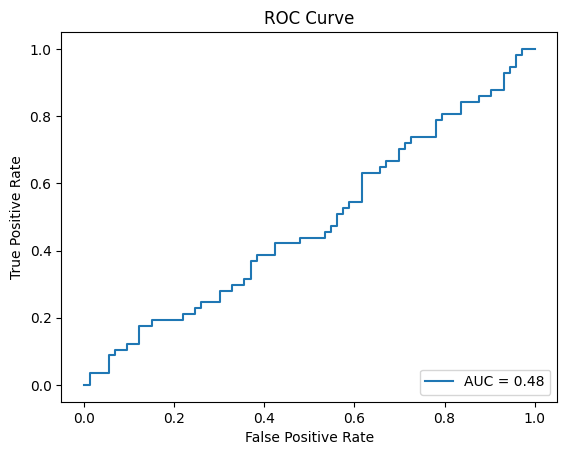

Epoch  6
Epoch: [6]/(10/26), Train Loss: 0.8253, Average Train Accuracy: 0.55, Average Train Precision: 0.40, Average Train Recall: 0.07, Average Train F1 Score: 0.12, Time: 23.03 sec
Epoch: [6]/(20/26), Train Loss: 0.6519, Average Train Accuracy: 0.58, Average Train Precision: 0.35, Average Train Recall: 0.06, Average Train F1 Score: 0.10, Time: 44.57 sec
Testing
Epoch: [6], Test Loss: 0.6980, Average Test Accuracy: 0.56, Average Test Precision: 0.26, Average Test Recall: 0.08, Average Test F1 Score: 0.11, Time: 11.21 sec


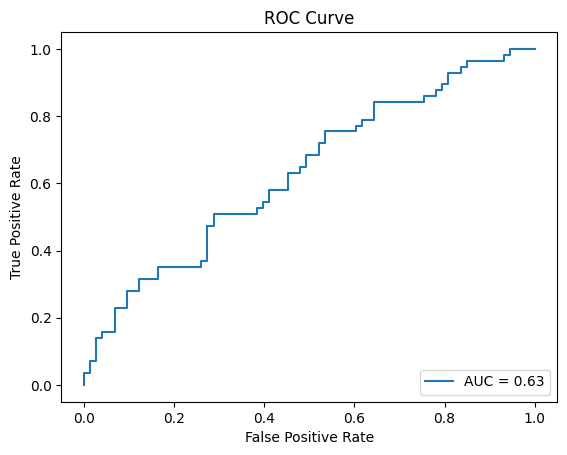

Epoch  7
Epoch: [7]/(10/26), Train Loss: 0.6005, Average Train Accuracy: 0.57, Average Train Precision: 0.05, Average Train Recall: 0.03, Average Train F1 Score: 0.04, Time: 21.77 sec
Epoch: [7]/(20/26), Train Loss: 0.7125, Average Train Accuracy: 0.57, Average Train Precision: 0.03, Average Train Recall: 0.02, Average Train F1 Score: 0.02, Time: 43.39 sec
Testing
Epoch: [7], Test Loss: 0.6912, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 8.70 sec


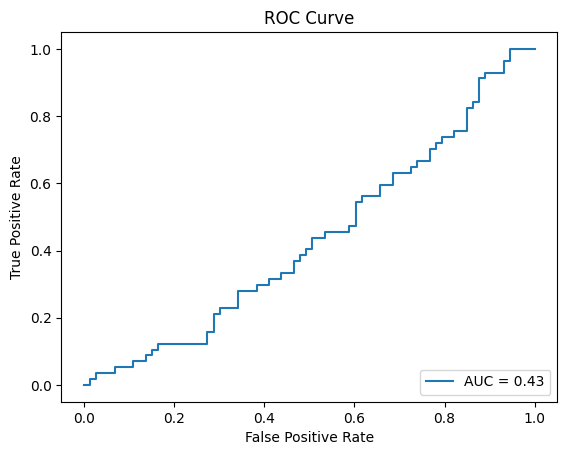

Epoch  8
Epoch: [8]/(10/26), Train Loss: 0.6978, Average Train Accuracy: 0.58, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 21.08 sec
Epoch: [8]/(20/26), Train Loss: 0.7168, Average Train Accuracy: 0.60, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 43.21 sec
Testing
Epoch: [8], Test Loss: 0.6989, Average Test Accuracy: 0.55, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.57 sec


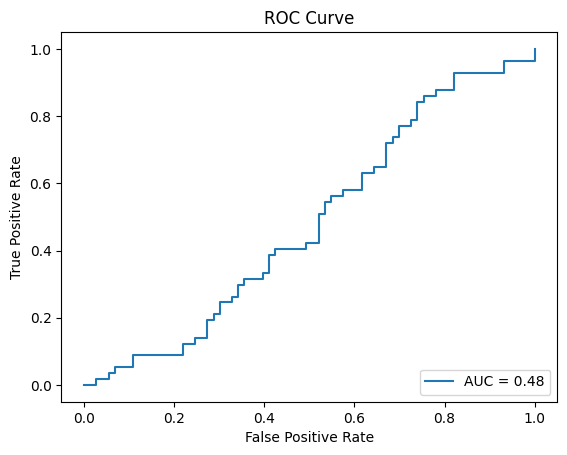

Epoch  9
Epoch: [9]/(10/26), Train Loss: 0.6469, Average Train Accuracy: 0.57, Average Train Precision: 0.10, Average Train Recall: 0.02, Average Train F1 Score: 0.03, Time: 23.40 sec
Epoch: [9]/(20/26), Train Loss: 0.6246, Average Train Accuracy: 0.57, Average Train Precision: 0.10, Average Train Recall: 0.03, Average Train F1 Score: 0.04, Time: 45.48 sec
Testing
Epoch: [9], Test Loss: 0.6857, Average Test Accuracy: 0.56, Average Test Precision: 0.18, Average Test Recall: 0.03, Average Test F1 Score: 0.06, Time: 9.92 sec


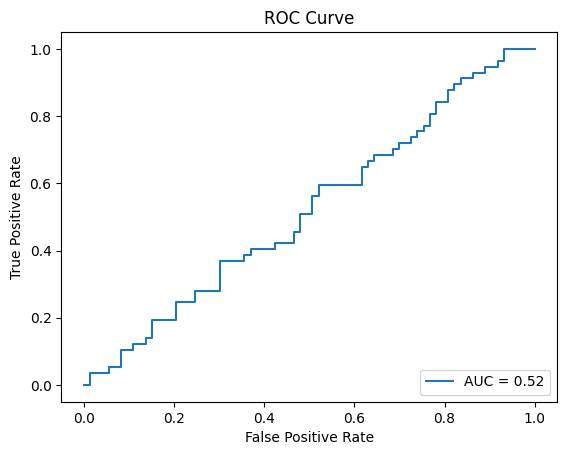

Epoch  10
Epoch: [10]/(10/26), Train Loss: 0.6234, Average Train Accuracy: 0.59, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 21.40 sec
Epoch: [10]/(20/26), Train Loss: 0.7474, Average Train Accuracy: 0.56, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 43.40 sec
Testing
Epoch: [10], Test Loss: 0.6861, Average Test Accuracy: 0.57, Average Test Precision: 0.09, Average Test Recall: 0.03, Average Test F1 Score: 0.05, Time: 8.73 sec


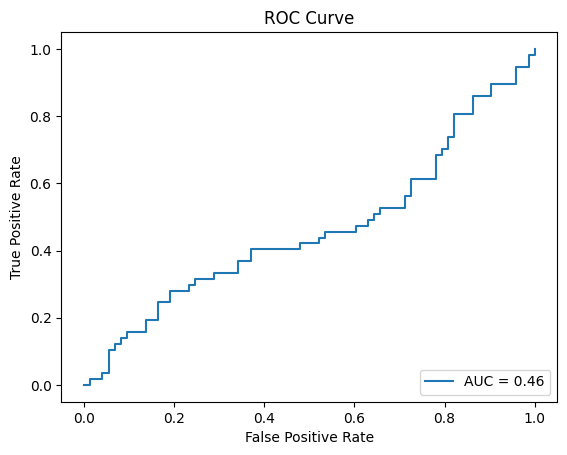

./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_10.pth
Epoch  11
Epoch: [11]/(10/26), Train Loss: 0.6835, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 22.40 sec
Epoch: [11]/(20/26), Train Loss: 0.6182, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 43.54 sec
Testing
Epoch: [11], Test Loss: 0.6888, Average Test Accuracy: 0.55, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.24 sec


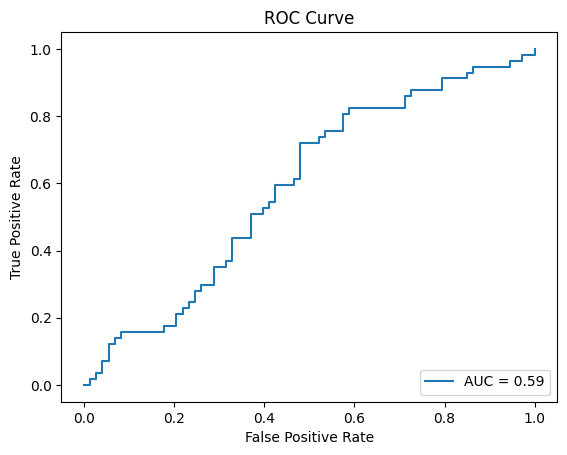

Epoch  12
Epoch: [12]/(10/26), Train Loss: 0.5880, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 23.14 sec
Epoch: [12]/(20/26), Train Loss: 0.5737, Average Train Accuracy: 0.59, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 44.35 sec
Testing
Epoch: [12], Test Loss: 0.6897, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.91 sec


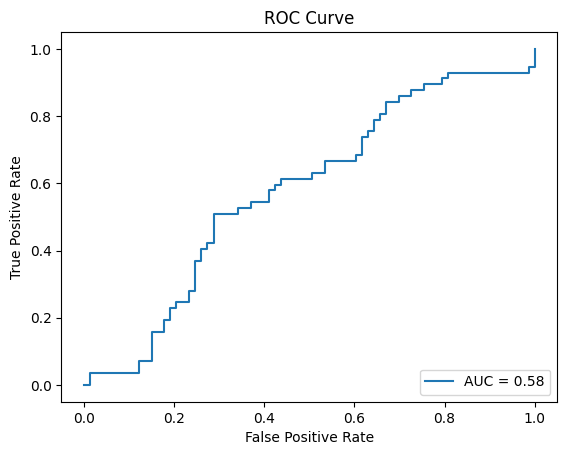

Epoch  13
Epoch: [13]/(10/26), Train Loss: 0.7202, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 21.63 sec
Epoch: [13]/(20/26), Train Loss: 0.6389, Average Train Accuracy: 0.59, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 45.13 sec
Testing
Epoch: [13], Test Loss: 0.6778, Average Test Accuracy: 0.57, Average Test Precision: 0.09, Average Test Recall: 0.02, Average Test F1 Score: 0.03, Time: 9.52 sec


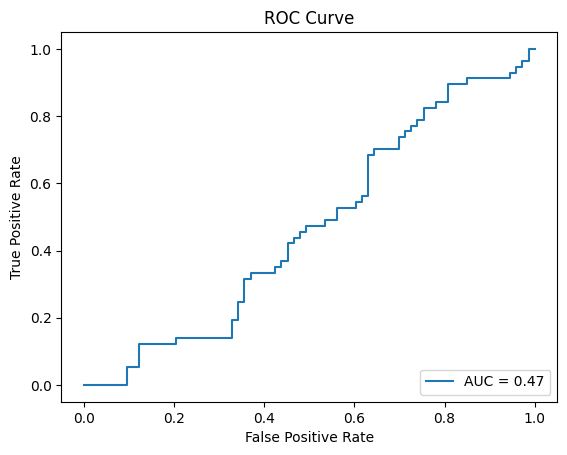

Epoch  14
Epoch: [14]/(10/26), Train Loss: 0.6711, Average Train Accuracy: 0.56, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 20.81 sec
Epoch: [14]/(20/26), Train Loss: 0.6553, Average Train Accuracy: 0.57, Average Train Precision: 0.05, Average Train Recall: 0.01, Average Train F1 Score: 0.02, Time: 44.12 sec
Testing
Epoch: [14], Test Loss: 0.6880, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.50 sec


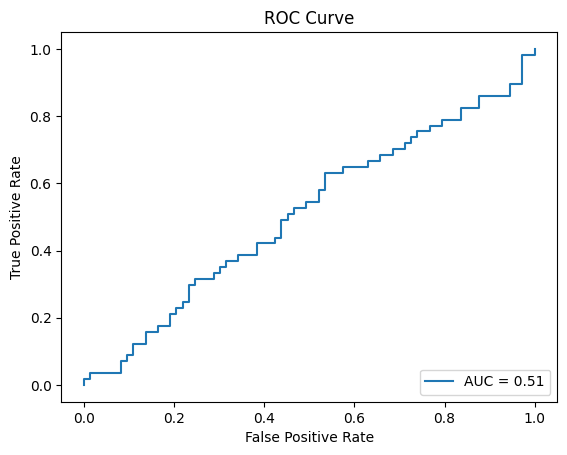

Epoch  15
Epoch: [15]/(10/26), Train Loss: 0.6519, Average Train Accuracy: 0.55, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 23.17 sec
Epoch: [15]/(20/26), Train Loss: 0.7907, Average Train Accuracy: 0.58, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 44.16 sec
Testing
Epoch: [15], Test Loss: 0.6917, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.82 sec


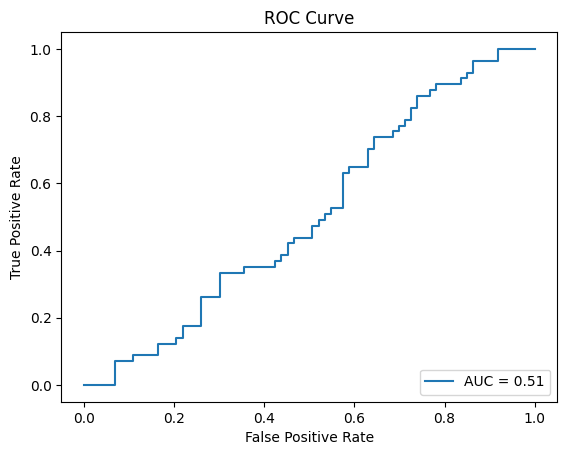

Epoch  16
Epoch: [16]/(10/26), Train Loss: 0.5917, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 21.36 sec
Epoch: [16]/(20/26), Train Loss: 0.7590, Average Train Accuracy: 0.59, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 47.19 sec
Testing
Epoch: [16], Test Loss: 0.6973, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.01 sec


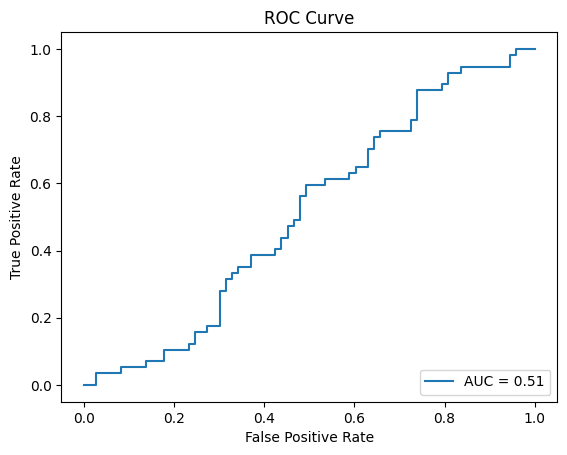

Epoch  17
Epoch: [17]/(10/26), Train Loss: 0.6490, Average Train Accuracy: 0.56, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 22.16 sec
Epoch: [17]/(20/26), Train Loss: 0.6208, Average Train Accuracy: 0.59, Average Train Precision: 0.10, Average Train Recall: 0.02, Average Train F1 Score: 0.04, Time: 42.91 sec
Testing
Epoch: [17], Test Loss: 0.6912, Average Test Accuracy: 0.55, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 11.62 sec


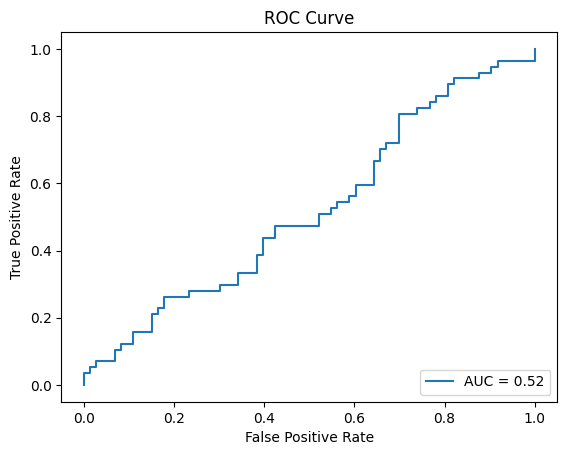

Epoch  18
Epoch: [18]/(10/26), Train Loss: 0.7551, Average Train Accuracy: 0.54, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 23.24 sec
Epoch: [18]/(20/26), Train Loss: 0.5887, Average Train Accuracy: 0.56, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 46.11 sec
Testing
Epoch: [18], Test Loss: 0.6936, Average Test Accuracy: 0.57, Average Test Precision: 0.09, Average Test Recall: 0.02, Average Test F1 Score: 0.04, Time: 9.63 sec


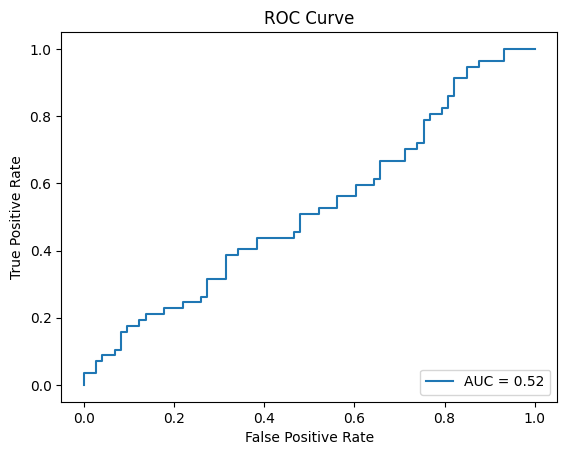

Epoch  19
Epoch: [19]/(10/26), Train Loss: 0.7235, Average Train Accuracy: 0.55, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 21.76 sec
Epoch: [19]/(20/26), Train Loss: 0.6895, Average Train Accuracy: 0.56, Average Train Precision: 0.05, Average Train Recall: 0.01, Average Train F1 Score: 0.01, Time: 44.62 sec
Testing
Epoch: [19], Test Loss: 0.6861, Average Test Accuracy: 0.57, Average Test Precision: 0.09, Average Test Recall: 0.01, Average Test F1 Score: 0.02, Time: 9.61 sec


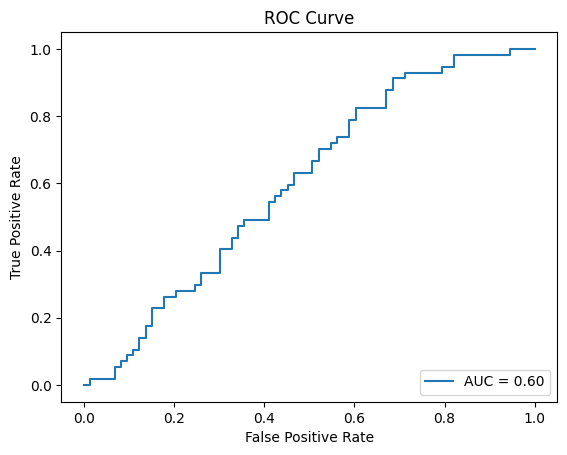

Epoch  20
Epoch: [20]/(10/26), Train Loss: 0.6759, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 22.69 sec
Epoch: [20]/(20/26), Train Loss: 0.6901, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 43.00 sec
Testing
Epoch: [20], Test Loss: 0.6879, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 10.08 sec


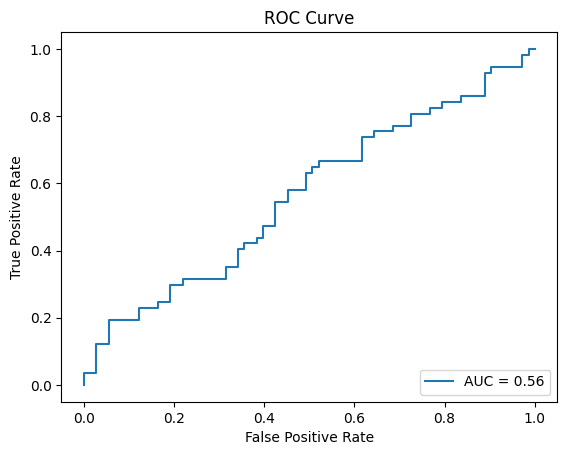

./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_20.pth
Epoch  21
Epoch: [21]/(10/26), Train Loss: 0.6766, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 21.40 sec
Epoch: [21]/(20/26), Train Loss: 0.6230, Average Train Accuracy: 0.61, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 44.49 sec
Testing
Epoch: [21], Test Loss: 0.6936, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 8.15 sec


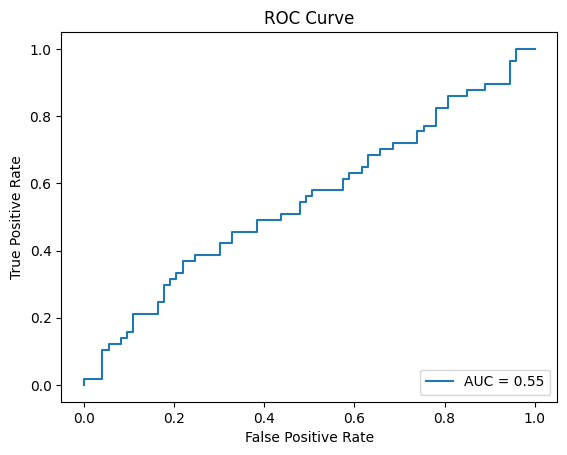

Epoch  22
Epoch: [22]/(10/26), Train Loss: 0.7130, Average Train Accuracy: 0.64, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 23.82 sec
Epoch: [22]/(20/26), Train Loss: 0.7176, Average Train Accuracy: 0.60, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 45.40 sec
Testing
Epoch: [22], Test Loss: 0.6947, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 10.03 sec


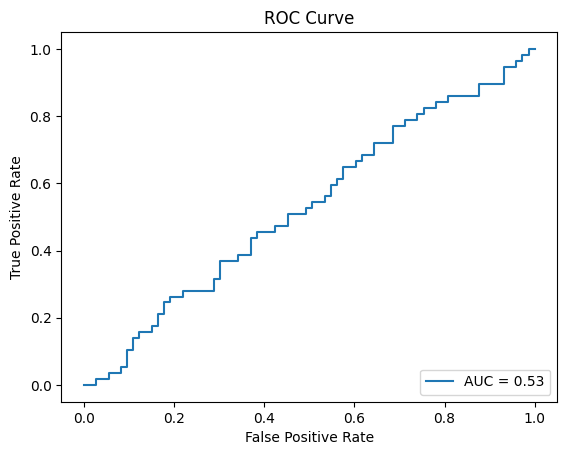

Epoch  23
Epoch: [23]/(10/26), Train Loss: 0.7474, Average Train Accuracy: 0.58, Average Train Precision: 0.10, Average Train Recall: 0.02, Average Train F1 Score: 0.03, Time: 23.03 sec
Epoch: [23]/(20/26), Train Loss: 0.6289, Average Train Accuracy: 0.60, Average Train Precision: 0.10, Average Train Recall: 0.02, Average Train F1 Score: 0.03, Time: 45.28 sec
Testing
Epoch: [23], Test Loss: 0.6883, Average Test Accuracy: 0.55, Average Test Precision: 0.09, Average Test Recall: 0.01, Average Test F1 Score: 0.02, Time: 9.48 sec


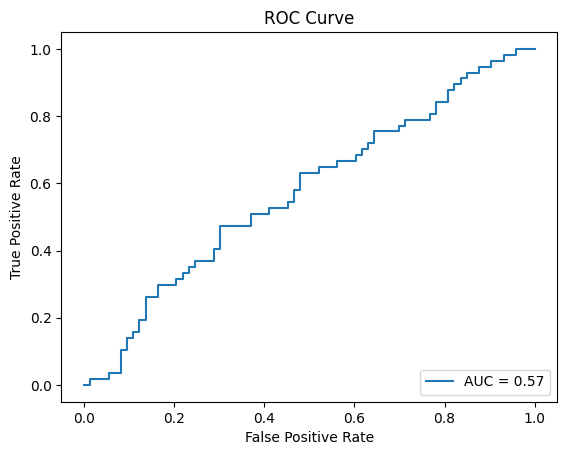

Epoch  24
Epoch: [24]/(10/26), Train Loss: 0.6468, Average Train Accuracy: 0.56, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 21.88 sec
Epoch: [24]/(20/26), Train Loss: 0.6704, Average Train Accuracy: 0.58, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 45.48 sec
Testing
Epoch: [24], Test Loss: 0.6852, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 7.66 sec


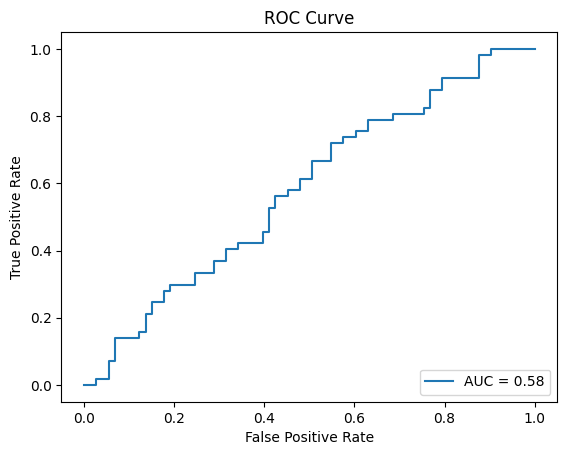

Epoch  25
Epoch: [25]/(10/26), Train Loss: 0.6878, Average Train Accuracy: 0.62, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 20.41 sec
Epoch: [25]/(20/26), Train Loss: 0.6486, Average Train Accuracy: 0.61, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 43.30 sec
Testing
Epoch: [25], Test Loss: 0.6908, Average Test Accuracy: 0.55, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.23 sec


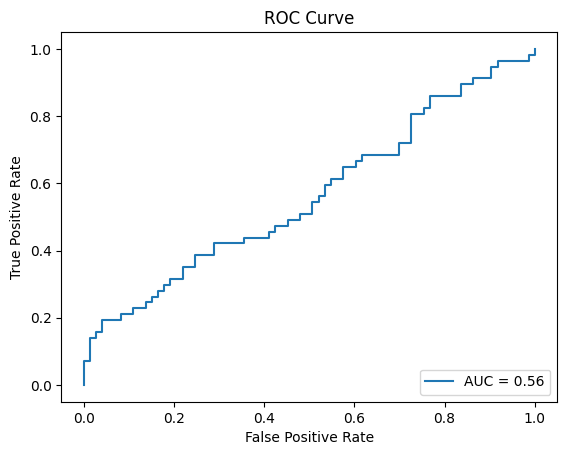

Epoch  26
Epoch: [26]/(10/26), Train Loss: 0.7257, Average Train Accuracy: 0.56, Average Train Precision: 0.10, Average Train Recall: 0.01, Average Train F1 Score: 0.02, Time: 23.05 sec
Epoch: [26]/(20/26), Train Loss: 0.6844, Average Train Accuracy: 0.57, Average Train Precision: 0.05, Average Train Recall: 0.01, Average Train F1 Score: 0.01, Time: 46.58 sec
Testing
Epoch: [26], Test Loss: 0.6845, Average Test Accuracy: 0.55, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 8.95 sec


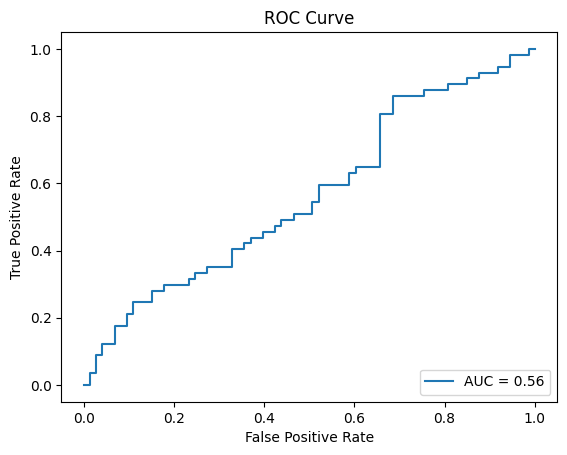

Epoch  27
Epoch: [27]/(10/26), Train Loss: 0.5608, Average Train Accuracy: 0.60, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 20.20 sec
Epoch: [27]/(20/26), Train Loss: 0.6250, Average Train Accuracy: 0.60, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 42.98 sec
Testing
Epoch: [27], Test Loss: 0.6958, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.48 sec


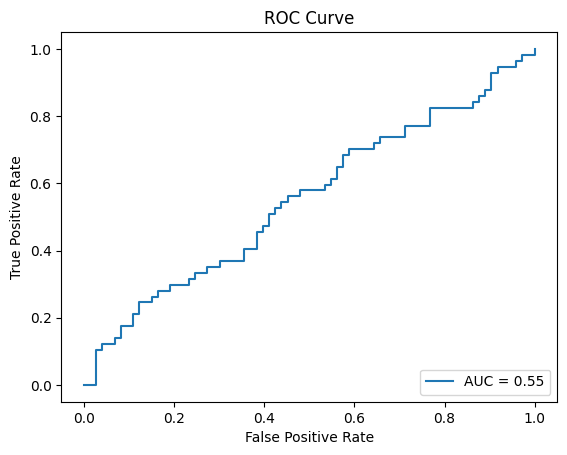

Epoch  28
Epoch: [28]/(10/26), Train Loss: 0.6903, Average Train Accuracy: 0.57, Average Train Precision: 0.10, Average Train Recall: 0.02, Average Train F1 Score: 0.03, Time: 22.40 sec
Epoch: [28]/(20/26), Train Loss: 0.6261, Average Train Accuracy: 0.58, Average Train Precision: 0.05, Average Train Recall: 0.01, Average Train F1 Score: 0.02, Time: 45.16 sec
Testing
Epoch: [28], Test Loss: 0.6891, Average Test Accuracy: 0.55, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 10.19 sec


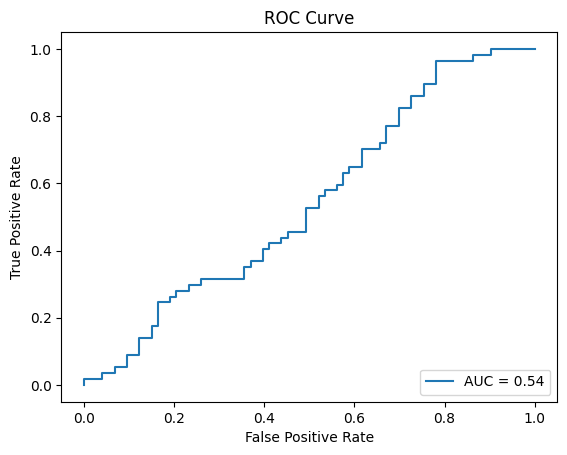

Epoch  29
Epoch: [29]/(10/26), Train Loss: 0.6040, Average Train Accuracy: 0.64, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 23.06 sec
Epoch: [29]/(20/26), Train Loss: 0.7729, Average Train Accuracy: 0.60, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 45.54 sec
Testing
Epoch: [29], Test Loss: 0.7044, Average Test Accuracy: 0.55, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.19 sec


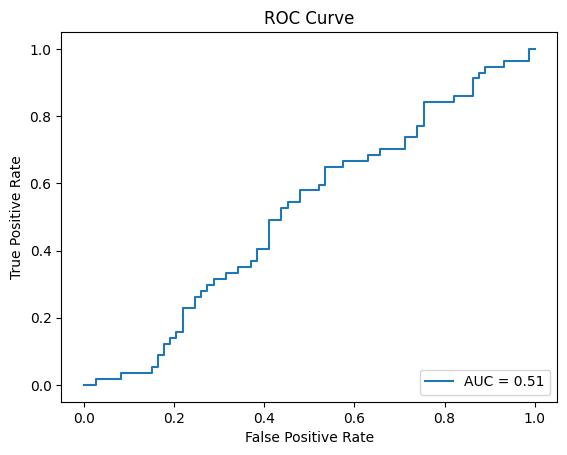

Epoch  30
Epoch: [30]/(10/26), Train Loss: 0.6180, Average Train Accuracy: 0.60, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 20.34 sec
Epoch: [30]/(20/26), Train Loss: 0.6627, Average Train Accuracy: 0.58, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 42.19 sec
Testing
Epoch: [30], Test Loss: 0.6859, Average Test Accuracy: 0.57, Average Test Precision: 0.09, Average Test Recall: 0.02, Average Test F1 Score: 0.03, Time: 11.37 sec


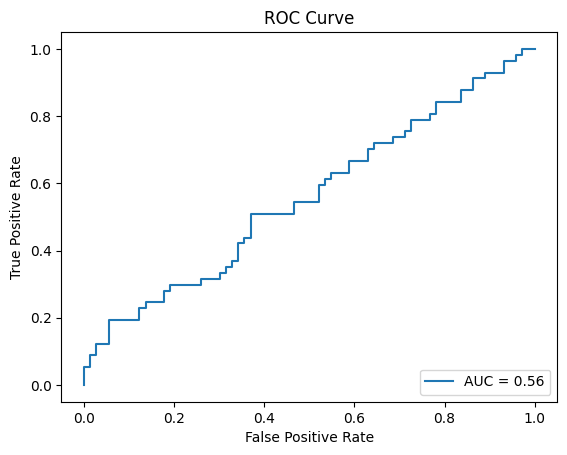

./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_30.pth
Epoch  31
Epoch: [31]/(10/26), Train Loss: 0.7513, Average Train Accuracy: 0.56, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 19.90 sec
Epoch: [31]/(20/26), Train Loss: 0.6240, Average Train Accuracy: 0.61, Average Train Precision: 0.05, Average Train Recall: 0.02, Average Train F1 Score: 0.03, Time: 41.07 sec
Testing
Epoch: [31], Test Loss: 0.6775, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 8.97 sec


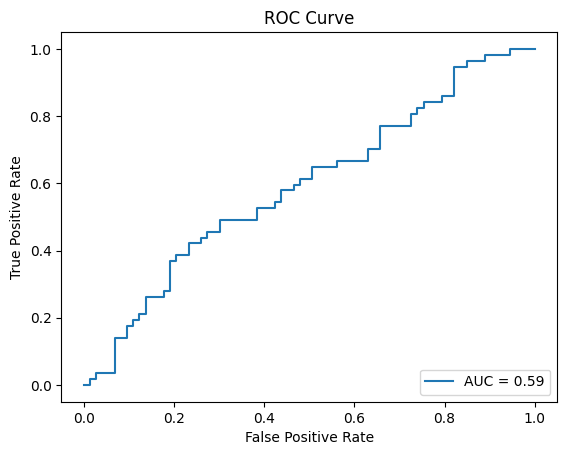

Epoch  32
Epoch: [32]/(10/26), Train Loss: 0.6542, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 22.41 sec
Epoch: [32]/(20/26), Train Loss: 0.7397, Average Train Accuracy: 0.57, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 44.49 sec
Testing
Epoch: [32], Test Loss: 0.6825, Average Test Accuracy: 0.56, Average Test Precision: 0.00, Average Test Recall: 0.00, Average Test F1 Score: 0.00, Time: 9.86 sec


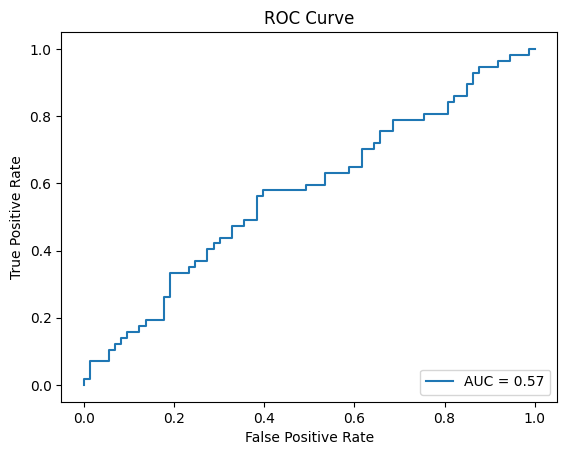

Epoch  33
Epoch: [33]/(10/26), Train Loss: 0.6387, Average Train Accuracy: 0.61, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 22.87 sec
Epoch: [33]/(20/26), Train Loss: 0.6639, Average Train Accuracy: 0.58, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 44.87 sec
Testing
Epoch: [33], Test Loss: 0.6816, Average Test Accuracy: 0.57, Average Test Precision: 0.09, Average Test Recall: 0.03, Average Test F1 Score: 0.05, Time: 9.91 sec


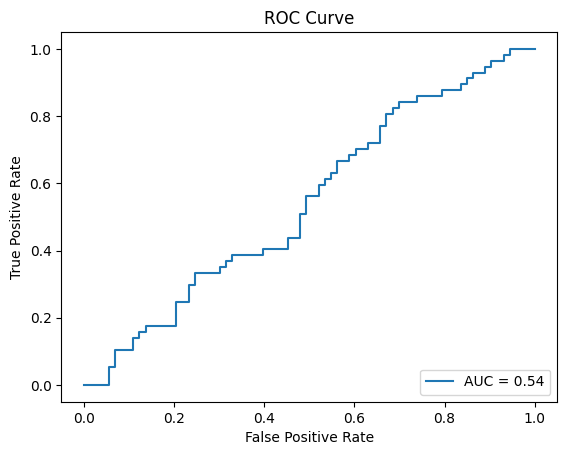

Epoch  34
Epoch: [34]/(10/26), Train Loss: 0.7205, Average Train Accuracy: 0.61, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 20.51 sec
Epoch: [34]/(20/26), Train Loss: 0.6723, Average Train Accuracy: 0.59, Average Train Precision: 0.25, Average Train Recall: 0.05, Average Train F1 Score: 0.08, Time: 41.20 sec
Testing
Epoch: [34], Test Loss: 0.6782, Average Test Accuracy: 0.55, Average Test Precision: 0.18, Average Test Recall: 0.04, Average Test F1 Score: 0.06, Time: 9.92 sec


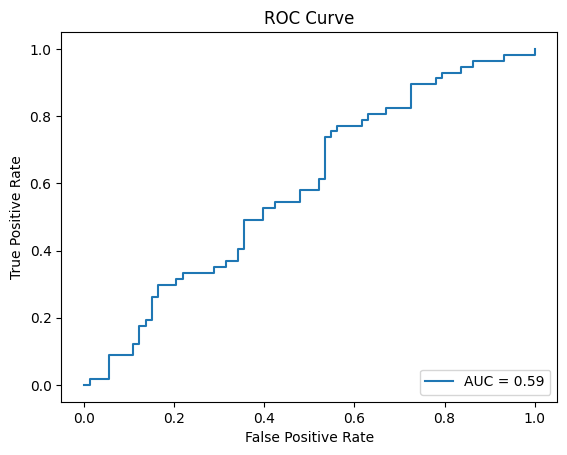

Epoch  35
Epoch: [35]/(10/26), Train Loss: 0.7433, Average Train Accuracy: 0.55, Average Train Precision: 0.00, Average Train Recall: 0.00, Average Train F1 Score: 0.00, Time: 22.89 sec
Epoch: [35]/(20/26), Train Loss: 0.6398, Average Train Accuracy: 0.59, Average Train Precision: 0.10, Average Train Recall: 0.03, Average Train F1 Score: 0.04, Time: 45.34 sec
Testing
Epoch: [35], Test Loss: 0.6902, Average Test Accuracy: 0.56, Average Test Precision: 0.18, Average Test Recall: 0.04, Average Test F1 Score: 0.06, Time: 8.98 sec


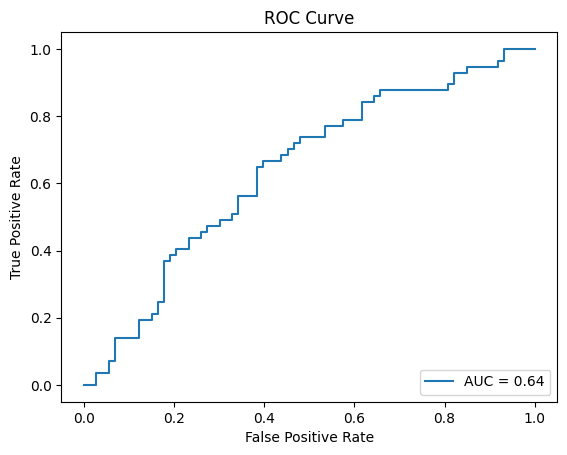

Epoch  36
Epoch: [36]/(10/26), Train Loss: 0.6197, Average Train Accuracy: 0.54, Average Train Precision: 0.20, Average Train Recall: 0.04, Average Train F1 Score: 0.07, Time: 21.59 sec
Epoch: [36]/(20/26), Train Loss: 0.6319, Average Train Accuracy: 0.61, Average Train Precision: 0.33, Average Train Recall: 0.10, Average Train F1 Score: 0.15, Time: 42.52 sec
Testing
Epoch: [36], Test Loss: 0.7116, Average Test Accuracy: 0.55, Average Test Precision: 0.09, Average Test Recall: 0.01, Average Test F1 Score: 0.02, Time: 9.82 sec


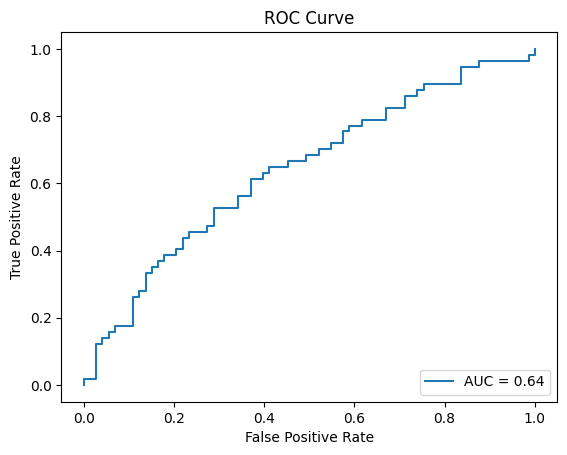

Epoch  37
Epoch: [37]/(10/26), Train Loss: 0.5753, Average Train Accuracy: 0.64, Average Train Precision: 0.10, Average Train Recall: 0.03, Average Train F1 Score: 0.04, Time: 22.44 sec
Epoch: [37]/(20/26), Train Loss: 0.7122, Average Train Accuracy: 0.61, Average Train Precision: 0.23, Average Train Recall: 0.05, Average Train F1 Score: 0.08, Time: 42.23 sec
Testing
* best recall =  0.4
Epoch: [37], Test Loss: 0.6720, Average Test Accuracy: 0.56, Average Test Precision: 0.44, Average Test Recall: 0.18, Average Test F1 Score: 0.24, Time: 9.81 sec


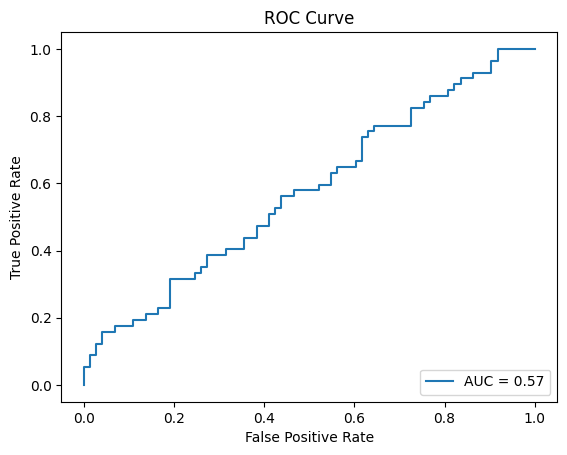

Epoch  38
Epoch: [38]/(10/26), Train Loss: 0.6408, Average Train Accuracy: 0.63, Average Train Precision: 0.56, Average Train Recall: 0.35, Average Train F1 Score: 0.40, Time: 21.87 sec
Epoch: [38]/(20/26), Train Loss: 0.6144, Average Train Accuracy: 0.62, Average Train Precision: 0.46, Average Train Recall: 0.22, Average Train F1 Score: 0.27, Time: 42.36 sec
Testing
* best recall =  0.5
* best f1_score =  0.6153846153846154
* best recall =  0.6
* best f1_score =  0.6666666666666665
Epoch: [38], Test Loss: 0.6727, Average Test Accuracy: 0.59, Average Test Precision: 0.54, Average Test Recall: 0.32, Average Test F1 Score: 0.38, Time: 9.91 sec


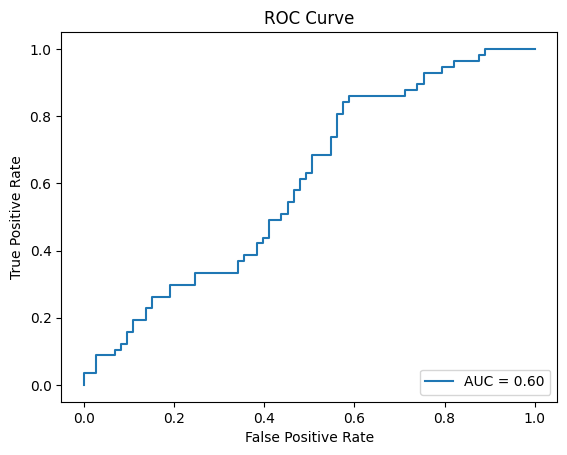

Epoch  39
Epoch: [39]/(10/26), Train Loss: 0.6088, Average Train Accuracy: 0.57, Average Train Precision: 0.48, Average Train Recall: 0.20, Average Train F1 Score: 0.26, Time: 19.82 sec
Epoch: [39]/(20/26), Train Loss: 0.6017, Average Train Accuracy: 0.57, Average Train Precision: 0.42, Average Train Recall: 0.14, Average Train F1 Score: 0.20, Time: 41.39 sec
Testing
Epoch: [39], Test Loss: 0.6696, Average Test Accuracy: 0.57, Average Test Precision: 0.48, Average Test Recall: 0.19, Average Test F1 Score: 0.27, Time: 9.81 sec


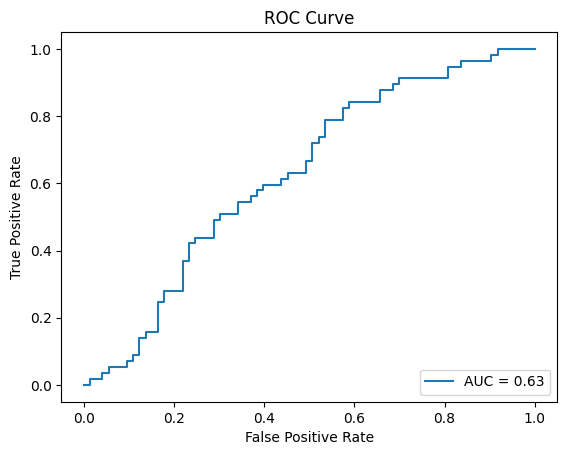

Epoch  40
Epoch: [40]/(10/26), Train Loss: 0.5544, Average Train Accuracy: 0.62, Average Train Precision: 0.40, Average Train Recall: 0.10, Average Train F1 Score: 0.16, Time: 22.00 sec
Epoch: [40]/(20/26), Train Loss: 0.6471, Average Train Accuracy: 0.60, Average Train Precision: 0.45, Average Train Recall: 0.12, Average Train F1 Score: 0.18, Time: 42.76 sec
Testing
* best acc =  0.9166666666666666
* best recall =  0.6666666666666666
* best f1_score =  0.8
Epoch: [40], Test Loss: 0.6731, Average Test Accuracy: 0.57, Average Test Precision: 0.52, Average Test Recall: 0.21, Average Test F1 Score: 0.27, Time: 9.97 sec


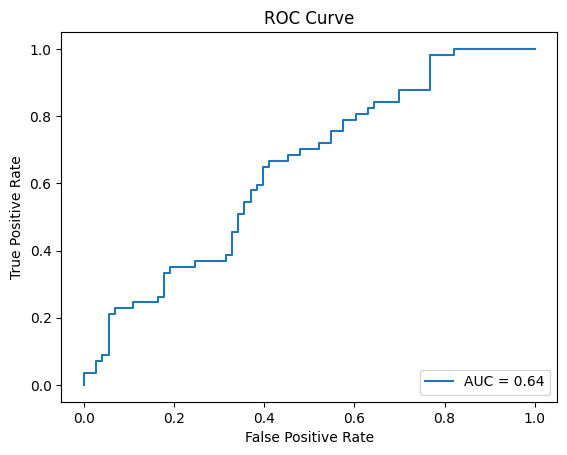

./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_40.pth
Epoch  41
Epoch: [41]/(10/26), Train Loss: 0.7683, Average Train Accuracy: 0.61, Average Train Precision: 0.50, Average Train Recall: 0.17, Average Train F1 Score: 0.23, Time: 21.05 sec
Epoch: [41]/(20/26), Train Loss: 0.6771, Average Train Accuracy: 0.57, Average Train Precision: 0.50, Average Train Recall: 0.24, Average Train F1 Score: 0.29, Time: 45.25 sec
Testing
Epoch: [41], Test Loss: 0.6814, Average Test Accuracy: 0.55, Average Test Precision: 0.28, Average Test Recall: 0.13, Average Test F1 Score: 0.16, Time: 8.43 sec


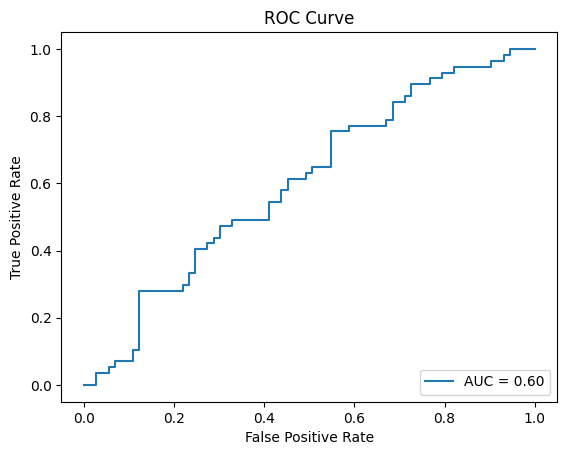

Epoch  42
Epoch: [42]/(10/26), Train Loss: 0.6621, Average Train Accuracy: 0.57, Average Train Precision: 0.21, Average Train Recall: 0.15, Average Train F1 Score: 0.13, Time: 22.09 sec
Epoch: [42]/(20/26), Train Loss: 0.7320, Average Train Accuracy: 0.59, Average Train Precision: 0.28, Average Train Recall: 0.11, Average Train F1 Score: 0.13, Time: 42.71 sec
Testing
Epoch: [42], Test Loss: 0.6529, Average Test Accuracy: 0.58, Average Test Precision: 0.27, Average Test Recall: 0.08, Average Test F1 Score: 0.11, Time: 9.14 sec


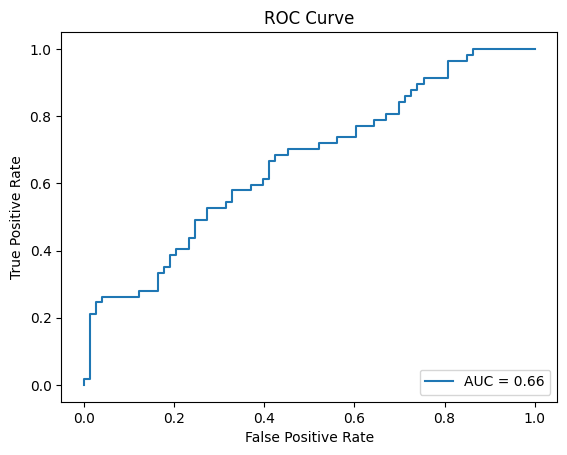

Epoch  43
Epoch: [43]/(10/26), Train Loss: 0.7114, Average Train Accuracy: 0.55, Average Train Precision: 0.32, Average Train Recall: 0.13, Average Train F1 Score: 0.17, Time: 21.99 sec
Epoch: [43]/(20/26), Train Loss: 0.5592, Average Train Accuracy: 0.58, Average Train Precision: 0.38, Average Train Recall: 0.17, Average Train F1 Score: 0.22, Time: 42.18 sec
Testing
Epoch: [43], Test Loss: 0.6628, Average Test Accuracy: 0.60, Average Test Precision: 0.41, Average Test Recall: 0.09, Average Test F1 Score: 0.14, Time: 8.83 sec


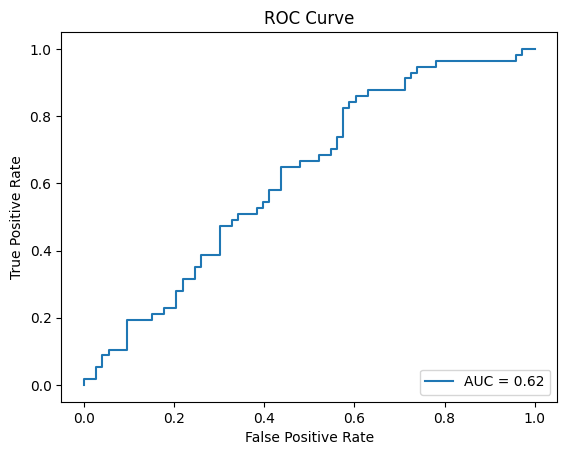

Epoch  44
Epoch: [44]/(10/26), Train Loss: 0.4574, Average Train Accuracy: 0.68, Average Train Precision: 0.25, Average Train Recall: 0.10, Average Train F1 Score: 0.14, Time: 22.02 sec
Epoch: [44]/(20/26), Train Loss: 0.6798, Average Train Accuracy: 0.61, Average Train Precision: 0.15, Average Train Recall: 0.06, Average Train F1 Score: 0.08, Time: 42.29 sec
Testing
* best recall =  0.8
Epoch: [44], Test Loss: 0.6707, Average Test Accuracy: 0.60, Average Test Precision: 0.56, Average Test Recall: 0.37, Average Test F1 Score: 0.41, Time: 9.96 sec


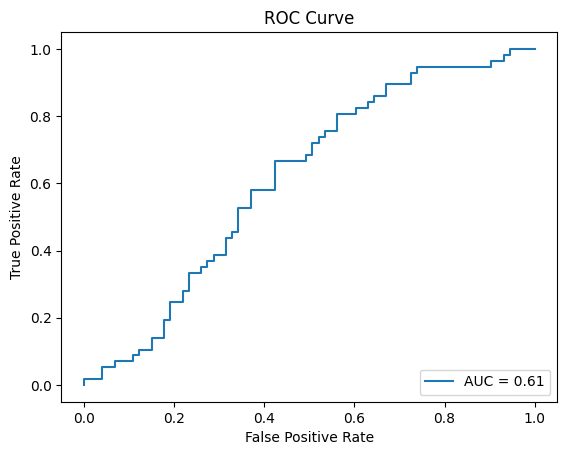

Epoch  45
Epoch: [45]/(10/26), Train Loss: 0.6226, Average Train Accuracy: 0.68, Average Train Precision: 0.60, Average Train Recall: 0.74, Average Train F1 Score: 0.64, Time: 22.44 sec
Epoch: [45]/(20/26), Train Loss: 0.6553, Average Train Accuracy: 0.64, Average Train Precision: 0.57, Average Train Recall: 0.64, Average Train F1 Score: 0.58, Time: 41.66 sec
Testing
Epoch: [45], Test Loss: 0.6431, Average Test Accuracy: 0.62, Average Test Precision: 0.65, Average Test Recall: 0.18, Average Test F1 Score: 0.27, Time: 11.27 sec


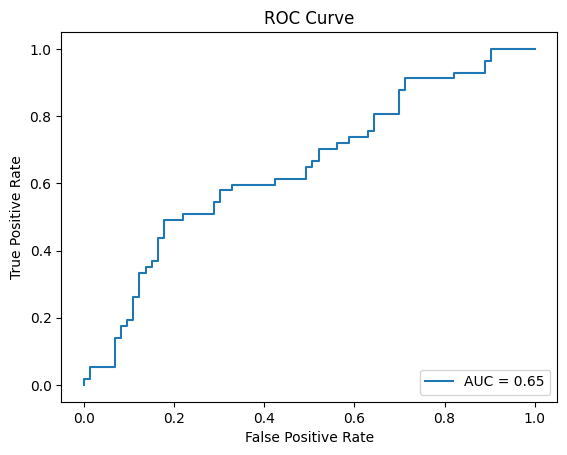

Epoch  46
Epoch: [46]/(10/26), Train Loss: 0.5285, Average Train Accuracy: 0.54, Average Train Precision: 0.10, Average Train Recall: 0.03, Average Train F1 Score: 0.05, Time: 22.16 sec
Epoch: [46]/(20/26), Train Loss: 0.6331, Average Train Accuracy: 0.58, Average Train Precision: 0.10, Average Train Recall: 0.03, Average Train F1 Score: 0.04, Time: 41.94 sec
Testing
Epoch: [46], Test Loss: 0.6920, Average Test Accuracy: 0.56, Average Test Precision: 0.09, Average Test Recall: 0.02, Average Test F1 Score: 0.04, Time: 9.87 sec


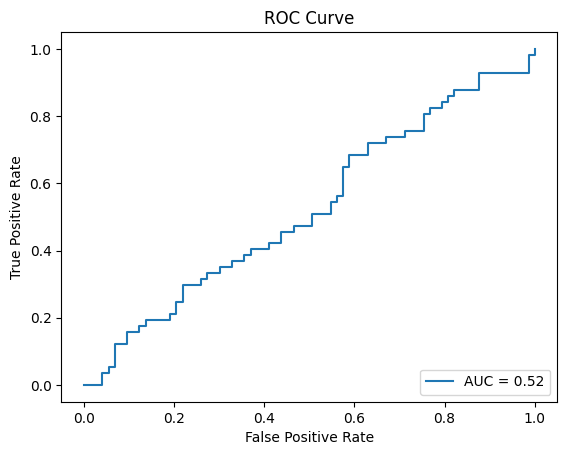

Epoch  47
Epoch: [47]/(10/26), Train Loss: 0.7577, Average Train Accuracy: 0.58, Average Train Precision: 0.10, Average Train Recall: 0.01, Average Train F1 Score: 0.03, Time: 20.62 sec
Epoch: [47]/(20/26), Train Loss: 0.3991, Average Train Accuracy: 0.59, Average Train Precision: 0.15, Average Train Recall: 0.03, Average Train F1 Score: 0.05, Time: 42.57 sec
Testing
Epoch: [47], Test Loss: 0.6629, Average Test Accuracy: 0.60, Average Test Precision: 0.45, Average Test Recall: 0.11, Average Test F1 Score: 0.18, Time: 8.81 sec


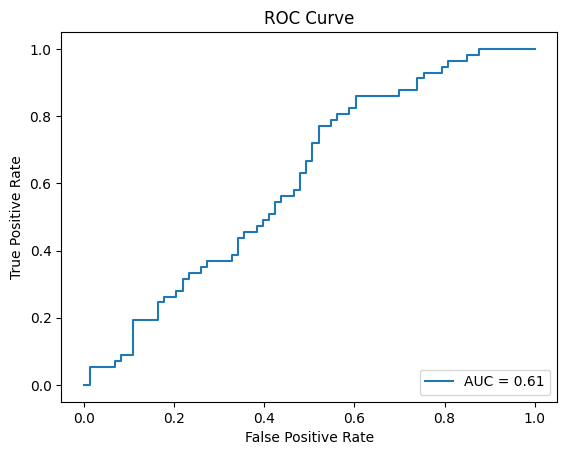

Epoch  48
Epoch: [48]/(10/26), Train Loss: 0.7197, Average Train Accuracy: 0.57, Average Train Precision: 0.35, Average Train Recall: 0.07, Average Train F1 Score: 0.11, Time: 19.61 sec
Epoch: [48]/(20/26), Train Loss: 0.6724, Average Train Accuracy: 0.58, Average Train Precision: 0.46, Average Train Recall: 0.16, Average Train F1 Score: 0.22, Time: 40.56 sec
Testing
Epoch: [48], Test Loss: 0.6892, Average Test Accuracy: 0.56, Average Test Precision: 0.50, Average Test Recall: 0.12, Average Test F1 Score: 0.19, Time: 9.89 sec


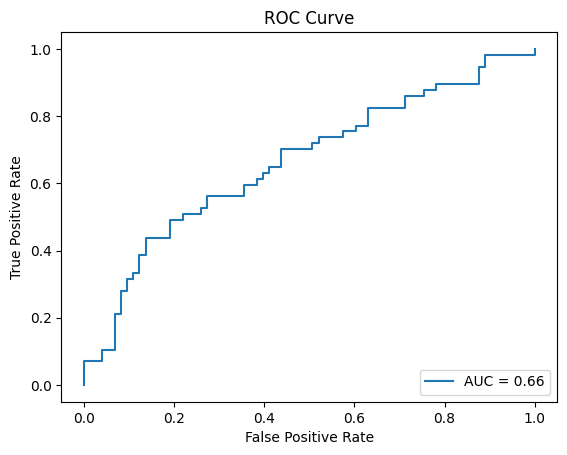

Epoch  49
Epoch: [49]/(10/26), Train Loss: 0.8525, Average Train Accuracy: 0.61, Average Train Precision: 0.23, Average Train Recall: 0.12, Average Train F1 Score: 0.15, Time: 20.78 sec
Epoch: [49]/(20/26), Train Loss: 0.6765, Average Train Accuracy: 0.65, Average Train Precision: 0.44, Average Train Recall: 0.18, Average Train F1 Score: 0.24, Time: 42.28 sec
Testing
Epoch: [49], Test Loss: 0.6573, Average Test Accuracy: 0.62, Average Test Precision: 0.72, Average Test Recall: 0.29, Average Test F1 Score: 0.38, Time: 9.15 sec


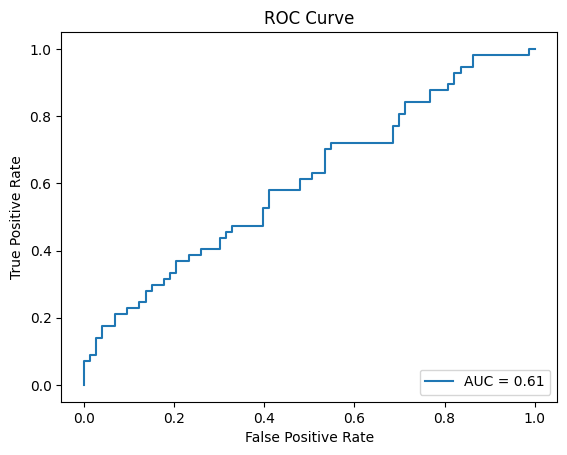

Epoch  50
Epoch: [50]/(10/26), Train Loss: 0.6186, Average Train Accuracy: 0.57, Average Train Precision: 0.55, Average Train Recall: 0.31, Average Train F1 Score: 0.36, Time: 24.23 sec
Epoch: [50]/(20/26), Train Loss: 0.7639, Average Train Accuracy: 0.57, Average Train Precision: 0.53, Average Train Recall: 0.23, Average Train F1 Score: 0.29, Time: 46.26 sec
Testing
Epoch: [50], Test Loss: 0.6974, Average Test Accuracy: 0.56, Average Test Precision: 0.32, Average Test Recall: 0.09, Average Test F1 Score: 0.13, Time: 9.88 sec


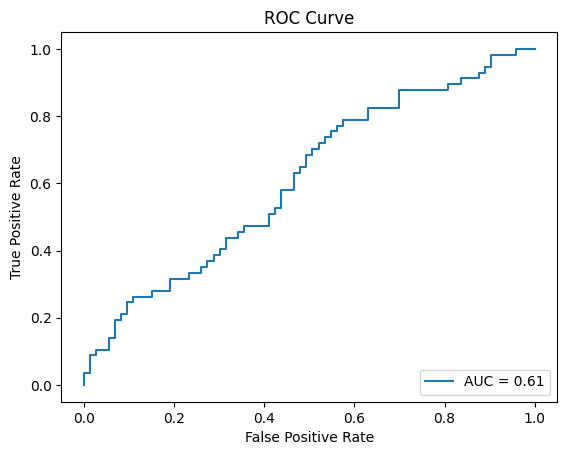

./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_50.pth
Epoch  51
Epoch: [51]/(10/26), Train Loss: 0.6125, Average Train Accuracy: 0.64, Average Train Precision: 0.20, Average Train Recall: 0.05, Average Train F1 Score: 0.08, Time: 22.33 sec
Epoch: [51]/(20/26), Train Loss: 0.5522, Average Train Accuracy: 0.66, Average Train Precision: 0.46, Average Train Recall: 0.22, Average Train F1 Score: 0.29, Time: 44.40 sec
Testing
Epoch: [51], Test Loss: 0.6464, Average Test Accuracy: 0.60, Average Test Precision: 0.54, Average Test Recall: 0.51, Average Test F1 Score: 0.50, Time: 8.83 sec


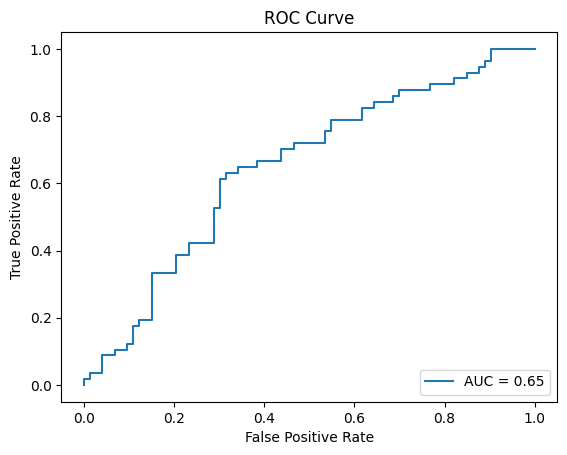

Epoch  52
Epoch: [52]/(10/26), Train Loss: 0.5578, Average Train Accuracy: 0.67, Average Train Precision: 0.54, Average Train Recall: 0.55, Average Train F1 Score: 0.54, Time: 22.88 sec
Epoch: [52]/(20/26), Train Loss: 0.6889, Average Train Accuracy: 0.63, Average Train Precision: 0.50, Average Train Recall: 0.38, Average Train F1 Score: 0.41, Time: 43.94 sec
Testing
Epoch: [52], Test Loss: 0.6345, Average Test Accuracy: 0.59, Average Test Precision: 0.56, Average Test Recall: 0.30, Average Test F1 Score: 0.35, Time: 9.89 sec


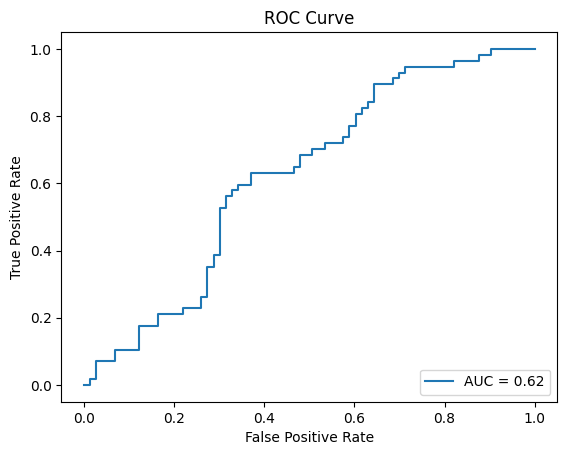

Epoch  53
Epoch: [53]/(10/26), Train Loss: 0.7223, Average Train Accuracy: 0.59, Average Train Precision: 0.60, Average Train Recall: 0.37, Average Train F1 Score: 0.40, Time: 21.03 sec
Epoch: [53]/(20/26), Train Loss: 0.5724, Average Train Accuracy: 0.65, Average Train Precision: 0.61, Average Train Recall: 0.43, Average Train F1 Score: 0.46, Time: 43.68 sec
Testing
* best recall =  1.0
Epoch: [53], Test Loss: 0.6279, Average Test Accuracy: 0.63, Average Test Precision: 0.65, Average Test Recall: 0.49, Average Test F1 Score: 0.51, Time: 8.70 sec


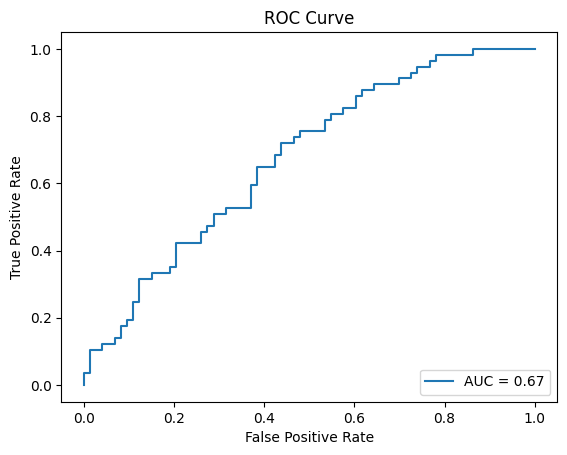

Epoch  54
Epoch: [54]/(10/26), Train Loss: 0.4726, Average Train Accuracy: 0.69, Average Train Precision: 0.68, Average Train Recall: 0.62, Average Train F1 Score: 0.63, Time: 24.30 sec
Epoch: [54]/(20/26), Train Loss: 1.1141, Average Train Accuracy: 0.68, Average Train Precision: 0.63, Average Train Recall: 0.60, Average Train F1 Score: 0.59, Time: 44.89 sec
Testing
* best f1_score =  0.8333333333333334
Epoch: [54], Test Loss: 0.7525, Average Test Accuracy: 0.60, Average Test Precision: 0.56, Average Test Recall: 0.63, Average Test F1 Score: 0.57, Time: 9.93 sec


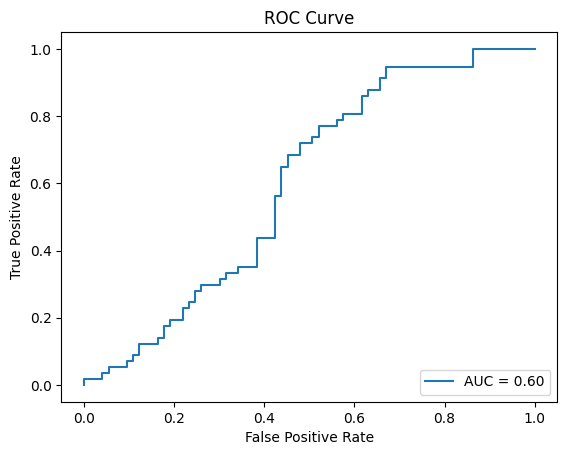

Epoch  55
Epoch: [55]/(10/26), Train Loss: 0.7753, Average Train Accuracy: 0.71, Average Train Precision: 0.69, Average Train Recall: 0.66, Average Train F1 Score: 0.65, Time: 23.23 sec
Epoch: [55]/(20/26), Train Loss: 0.7052, Average Train Accuracy: 0.73, Average Train Precision: 0.67, Average Train Recall: 0.75, Average Train F1 Score: 0.68, Time: 45.04 sec
Testing
Epoch: [55], Test Loss: 0.6348, Average Test Accuracy: 0.60, Average Test Precision: 0.57, Average Test Recall: 0.43, Average Test F1 Score: 0.46, Time: 9.88 sec


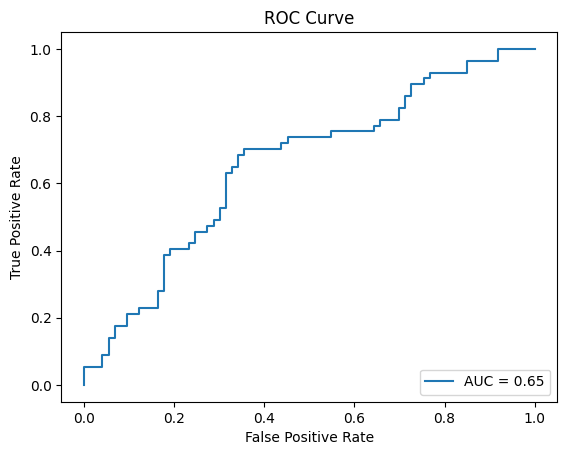

Epoch  56
Epoch: [56]/(10/26), Train Loss: 0.7383, Average Train Accuracy: 0.65, Average Train Precision: 0.57, Average Train Recall: 0.44, Average Train F1 Score: 0.47, Time: 23.11 sec
Epoch: [56]/(20/26), Train Loss: 0.5698, Average Train Accuracy: 0.68, Average Train Precision: 0.58, Average Train Recall: 0.46, Average Train F1 Score: 0.48, Time: 45.19 sec
Testing
Epoch: [56], Test Loss: 0.6335, Average Test Accuracy: 0.62, Average Test Precision: 0.63, Average Test Recall: 0.33, Average Test F1 Score: 0.39, Time: 8.82 sec


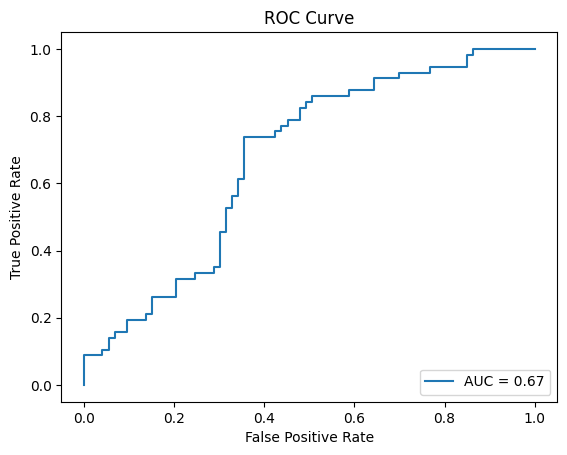

Epoch  57
Epoch: [57]/(10/26), Train Loss: 0.5318, Average Train Accuracy: 0.71, Average Train Precision: 0.61, Average Train Recall: 0.56, Average Train F1 Score: 0.55, Time: 23.01 sec
Epoch: [57]/(20/26), Train Loss: 0.5502, Average Train Accuracy: 0.72, Average Train Precision: 0.66, Average Train Recall: 0.52, Average Train F1 Score: 0.56, Time: 44.49 sec
Testing
* best f1_score =  0.8571428571428571
Epoch: [57], Test Loss: 0.6168, Average Test Accuracy: 0.67, Average Test Precision: 0.61, Average Test Recall: 0.64, Average Test F1 Score: 0.60, Time: 9.94 sec


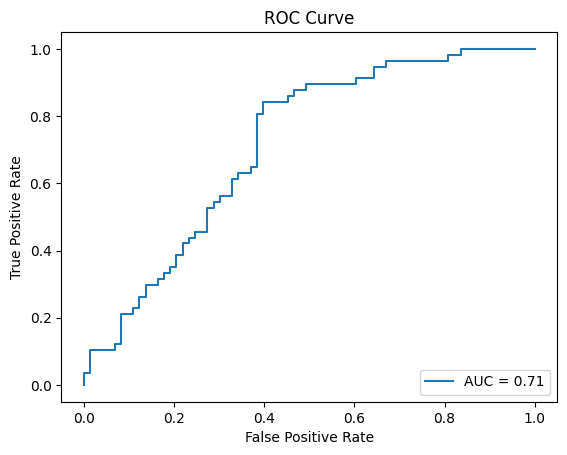

Epoch  58
Epoch: [58]/(10/26), Train Loss: 0.5636, Average Train Accuracy: 0.71, Average Train Precision: 0.66, Average Train Recall: 0.62, Average Train F1 Score: 0.63, Time: 23.28 sec
Epoch: [58]/(20/26), Train Loss: 0.6606, Average Train Accuracy: 0.69, Average Train Precision: 0.64, Average Train Recall: 0.61, Average Train F1 Score: 0.60, Time: 46.81 sec
Testing
Epoch: [58], Test Loss: 0.6123, Average Test Accuracy: 0.66, Average Test Precision: 0.61, Average Test Recall: 0.55, Average Test F1 Score: 0.55, Time: 7.93 sec


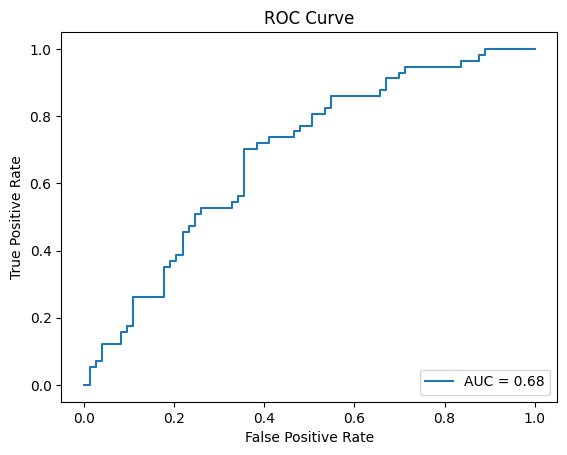

Epoch  59
Epoch: [59]/(10/26), Train Loss: 0.5316, Average Train Accuracy: 0.74, Average Train Precision: 0.60, Average Train Recall: 0.82, Average Train F1 Score: 0.65, Time: 19.24 sec
Epoch: [59]/(20/26), Train Loss: 0.6647, Average Train Accuracy: 0.70, Average Train Precision: 0.63, Average Train Recall: 0.70, Average Train F1 Score: 0.61, Time: 40.29 sec
Testing
Epoch: [59], Test Loss: 0.6503, Average Test Accuracy: 0.55, Average Test Precision: 0.48, Average Test Recall: 0.18, Average Test F1 Score: 0.25, Time: 8.58 sec


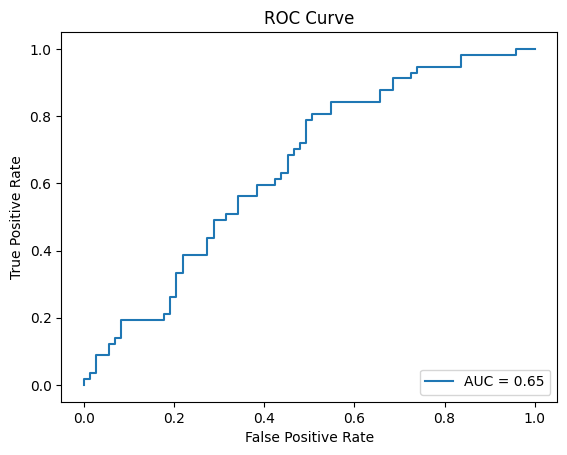

Epoch  60
Epoch: [60]/(10/26), Train Loss: 0.6630, Average Train Accuracy: 0.72, Average Train Precision: 0.46, Average Train Recall: 0.28, Average Train F1 Score: 0.33, Time: 20.01 sec
Epoch: [60]/(20/26), Train Loss: 0.8719, Average Train Accuracy: 0.68, Average Train Precision: 0.58, Average Train Recall: 0.38, Average Train F1 Score: 0.43, Time: 43.88 sec
Testing
Epoch: [60], Test Loss: 0.6350, Average Test Accuracy: 0.65, Average Test Precision: 0.60, Average Test Recall: 0.80, Average Test F1 Score: 0.65, Time: 8.64 sec


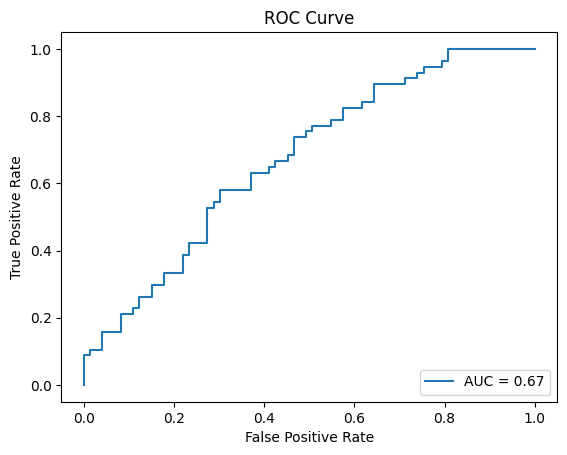

./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_60.pth
Epoch  61
Epoch: [61]/(10/26), Train Loss: 0.4634, Average Train Accuracy: 0.75, Average Train Precision: 0.59, Average Train Recall: 0.79, Average Train F1 Score: 0.67, Time: 21.87 sec
Epoch: [61]/(20/26), Train Loss: 0.4060, Average Train Accuracy: 0.74, Average Train Precision: 0.67, Average Train Recall: 0.72, Average Train F1 Score: 0.66, Time: 41.62 sec
Testing
Epoch: [61], Test Loss: 0.6677, Average Test Accuracy: 0.60, Average Test Precision: 0.48, Average Test Recall: 0.34, Average Test F1 Score: 0.39, Time: 9.34 sec


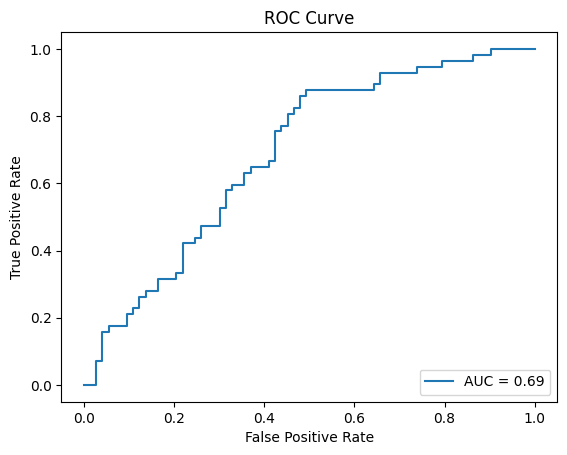

Epoch  62
Epoch: [62]/(10/26), Train Loss: 0.8018, Average Train Accuracy: 0.78, Average Train Precision: 0.76, Average Train Recall: 0.75, Average Train F1 Score: 0.74, Time: 21.65 sec
Epoch: [62]/(20/26), Train Loss: 0.6776, Average Train Accuracy: 0.74, Average Train Precision: 0.71, Average Train Recall: 0.63, Average Train F1 Score: 0.64, Time: 42.60 sec
Testing
Epoch: [62], Test Loss: 0.6349, Average Test Accuracy: 0.57, Average Test Precision: 0.52, Average Test Recall: 0.37, Average Test F1 Score: 0.40, Time: 9.90 sec


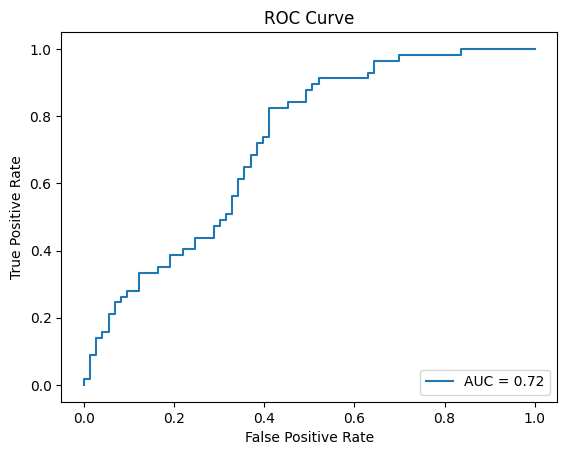

Epoch  63
Epoch: [63]/(10/26), Train Loss: 0.2911, Average Train Accuracy: 0.78, Average Train Precision: 0.77, Average Train Recall: 0.69, Average Train F1 Score: 0.71, Time: 22.27 sec
Epoch: [63]/(20/26), Train Loss: 0.6678, Average Train Accuracy: 0.74, Average Train Precision: 0.71, Average Train Recall: 0.72, Average Train F1 Score: 0.68, Time: 42.06 sec
Testing
Epoch: [63], Test Loss: 0.5979, Average Test Accuracy: 0.65, Average Test Precision: 0.60, Average Test Recall: 0.64, Average Test F1 Score: 0.59, Time: 9.98 sec


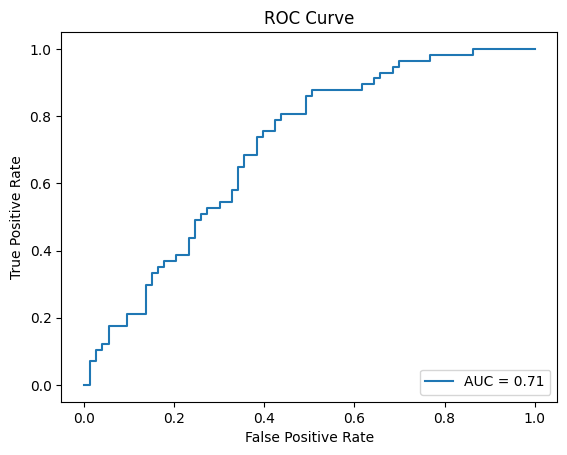

Epoch  64
Epoch: [64]/(10/26), Train Loss: 0.6026, Average Train Accuracy: 0.70, Average Train Precision: 0.60, Average Train Recall: 0.67, Average Train F1 Score: 0.61, Time: 21.62 sec
Epoch: [64]/(20/26), Train Loss: 0.6322, Average Train Accuracy: 0.73, Average Train Precision: 0.66, Average Train Recall: 0.69, Average Train F1 Score: 0.65, Time: 42.81 sec
Testing
Epoch: [64], Test Loss: 0.6461, Average Test Accuracy: 0.67, Average Test Precision: 0.61, Average Test Recall: 0.72, Average Test F1 Score: 0.64, Time: 9.90 sec


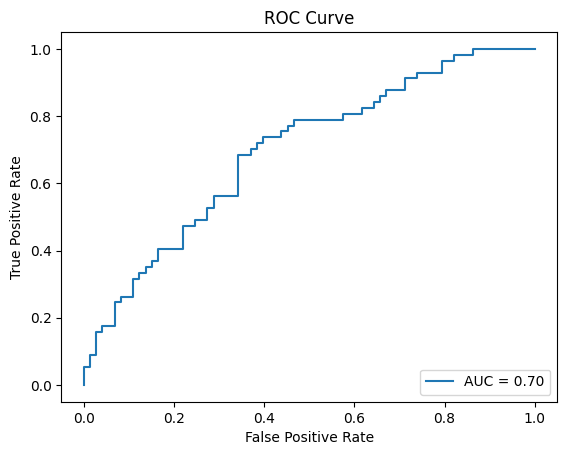

Epoch  65
Epoch: [65]/(10/26), Train Loss: 0.6304, Average Train Accuracy: 0.76, Average Train Precision: 0.64, Average Train Recall: 0.83, Average Train F1 Score: 0.71, Time: 22.01 sec
Epoch: [65]/(20/26), Train Loss: 0.6824, Average Train Accuracy: 0.77, Average Train Precision: 0.69, Average Train Recall: 0.75, Average Train F1 Score: 0.69, Time: 44.31 sec
Testing
Epoch: [65], Test Loss: 0.6186, Average Test Accuracy: 0.66, Average Test Precision: 0.59, Average Test Recall: 0.70, Average Test F1 Score: 0.63, Time: 8.88 sec


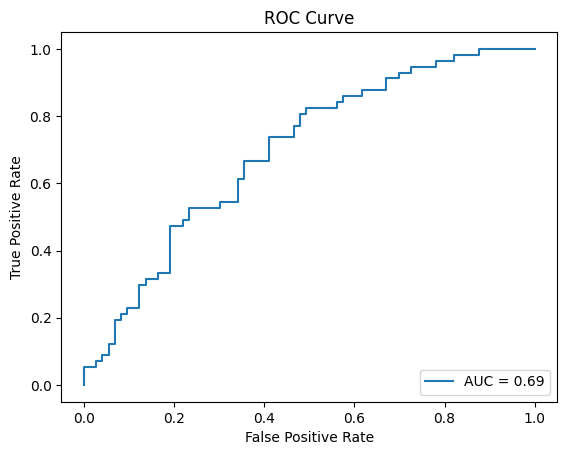

Epoch  66
Epoch: [66]/(10/26), Train Loss: 0.2711, Average Train Accuracy: 0.76, Average Train Precision: 0.66, Average Train Recall: 0.70, Average Train F1 Score: 0.62, Time: 22.38 sec
Epoch: [66]/(20/26), Train Loss: 0.3668, Average Train Accuracy: 0.75, Average Train Precision: 0.76, Average Train Recall: 0.63, Average Train F1 Score: 0.64, Time: 45.33 sec
Testing
* best f1_score =  0.923076923076923
Epoch: [66], Test Loss: 0.6112, Average Test Accuracy: 0.68, Average Test Precision: 0.61, Average Test Recall: 0.71, Average Test F1 Score: 0.64, Time: 9.96 sec


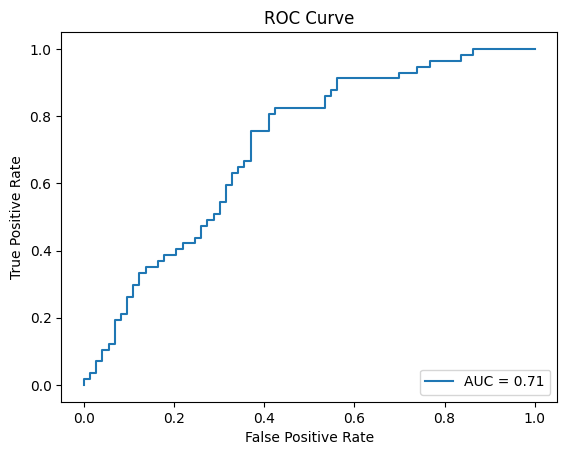

Epoch  67
Epoch: [67]/(10/26), Train Loss: 0.5019, Average Train Accuracy: 0.68, Average Train Precision: 0.70, Average Train Recall: 0.51, Average Train F1 Score: 0.55, Time: 22.71 sec
Epoch: [67]/(20/26), Train Loss: 0.4455, Average Train Accuracy: 0.72, Average Train Precision: 0.72, Average Train Recall: 0.59, Average Train F1 Score: 0.61, Time: 42.43 sec
Testing
Epoch: [67], Test Loss: 0.6485, Average Test Accuracy: 0.64, Average Test Precision: 0.61, Average Test Recall: 0.60, Average Test F1 Score: 0.57, Time: 9.95 sec


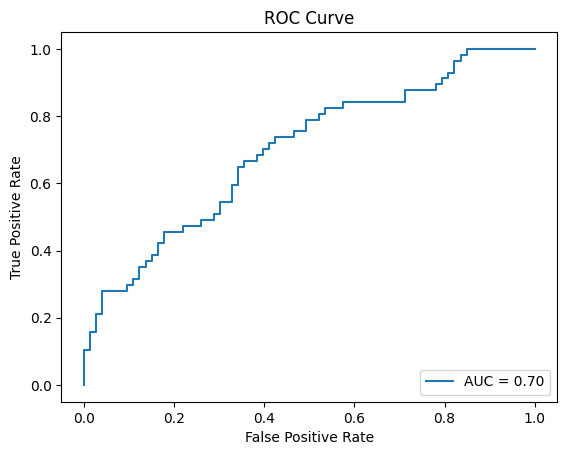

Epoch  68
Epoch: [68]/(10/26), Train Loss: 0.5948, Average Train Accuracy: 0.82, Average Train Precision: 0.77, Average Train Recall: 0.82, Average Train F1 Score: 0.77, Time: 21.87 sec
Epoch: [68]/(20/26), Train Loss: 0.4654, Average Train Accuracy: 0.79, Average Train Precision: 0.72, Average Train Recall: 0.83, Average Train F1 Score: 0.75, Time: 45.66 sec
Testing
Epoch: [68], Test Loss: 0.7342, Average Test Accuracy: 0.61, Average Test Precision: 0.53, Average Test Recall: 0.35, Average Test F1 Score: 0.39, Time: 9.72 sec


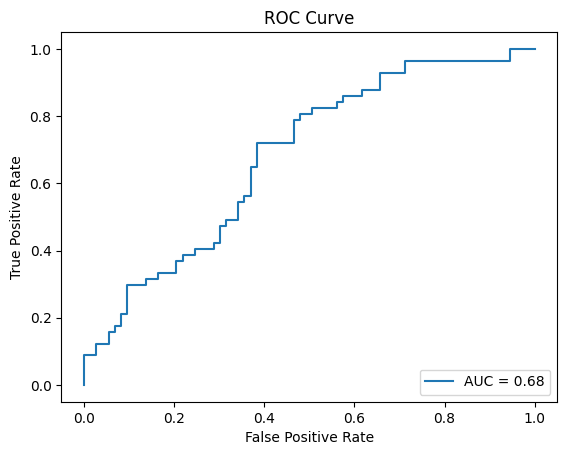

Epoch  69
Epoch: [69]/(10/26), Train Loss: 0.4092, Average Train Accuracy: 0.80, Average Train Precision: 0.74, Average Train Recall: 0.78, Average Train F1 Score: 0.75, Time: 21.47 sec
Epoch: [69]/(20/26), Train Loss: 0.5834, Average Train Accuracy: 0.78, Average Train Precision: 0.75, Average Train Recall: 0.78, Average Train F1 Score: 0.74, Time: 43.56 sec
Testing
* best acc =  1.0
* best f1_score =  1.0
Epoch: [69], Test Loss: 0.6480, Average Test Accuracy: 0.65, Average Test Precision: 0.62, Average Test Recall: 0.58, Average Test F1 Score: 0.58, Time: 8.65 sec


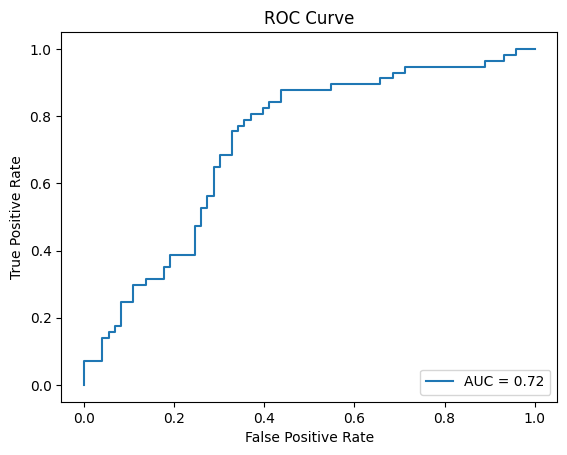

Epoch  70
Epoch: [70]/(10/26), Train Loss: 0.3870, Average Train Accuracy: 0.75, Average Train Precision: 0.62, Average Train Recall: 0.77, Average Train F1 Score: 0.67, Time: 22.84 sec
Epoch: [70]/(20/26), Train Loss: 0.3229, Average Train Accuracy: 0.78, Average Train Precision: 0.73, Average Train Recall: 0.78, Average Train F1 Score: 0.74, Time: 43.83 sec
Testing
Epoch: [70], Test Loss: 0.6040, Average Test Accuracy: 0.66, Average Test Precision: 0.61, Average Test Recall: 0.61, Average Test F1 Score: 0.59, Time: 9.83 sec


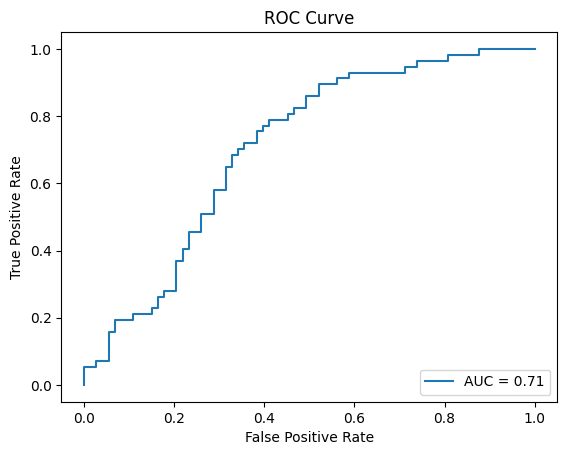

./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_70.pth
Epoch  71
Epoch: [71]/(10/26), Train Loss: 0.3694, Average Train Accuracy: 0.78, Average Train Precision: 0.68, Average Train Recall: 0.77, Average Train F1 Score: 0.71, Time: 21.74 sec
Epoch: [71]/(20/26), Train Loss: 0.7647, Average Train Accuracy: 0.80, Average Train Precision: 0.75, Average Train Recall: 0.82, Average Train F1 Score: 0.76, Time: 45.79 sec
Testing
Epoch: [71], Test Loss: 0.7118, Average Test Accuracy: 0.64, Average Test Precision: 0.58, Average Test Recall: 0.50, Average Test F1 Score: 0.52, Time: 8.83 sec


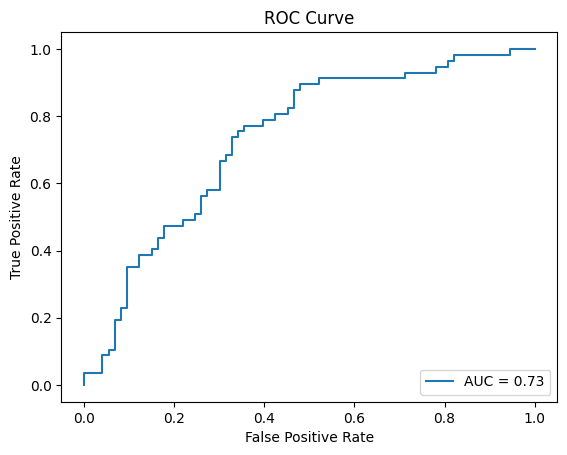

Epoch  72
Epoch: [72]/(10/26), Train Loss: 0.6830, Average Train Accuracy: 0.84, Average Train Precision: 0.79, Average Train Recall: 0.86, Average Train F1 Score: 0.80, Time: 21.98 sec
Epoch: [72]/(20/26), Train Loss: 0.4417, Average Train Accuracy: 0.80, Average Train Precision: 0.74, Average Train Recall: 0.83, Average Train F1 Score: 0.76, Time: 45.00 sec
Testing
Epoch: [72], Test Loss: 0.6543, Average Test Accuracy: 0.62, Average Test Precision: 0.61, Average Test Recall: 0.55, Average Test F1 Score: 0.53, Time: 9.98 sec


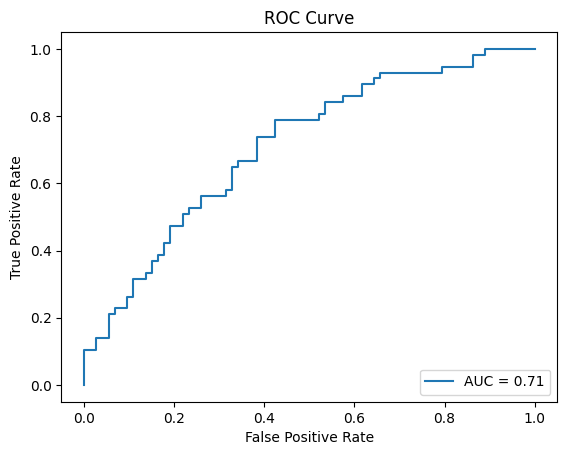

Epoch  73
Epoch: [73]/(10/26), Train Loss: 0.4956, Average Train Accuracy: 0.83, Average Train Precision: 0.78, Average Train Recall: 0.92, Average Train F1 Score: 0.83, Time: 22.80 sec
Epoch: [73]/(20/26), Train Loss: 0.7831, Average Train Accuracy: 0.78, Average Train Precision: 0.75, Average Train Recall: 0.83, Average Train F1 Score: 0.76, Time: 45.90 sec
Testing
Epoch: [73], Test Loss: 0.6631, Average Test Accuracy: 0.65, Average Test Precision: 0.61, Average Test Recall: 0.69, Average Test F1 Score: 0.61, Time: 9.88 sec


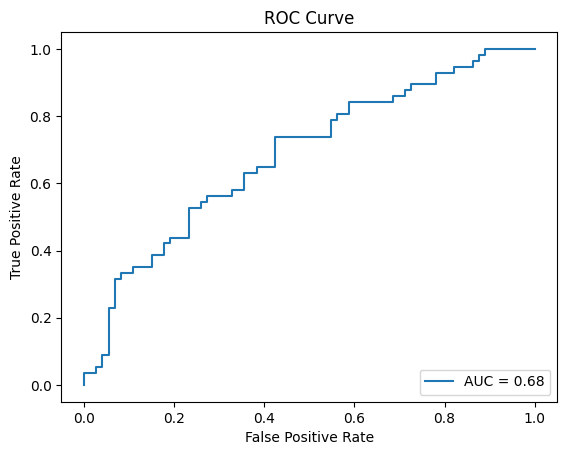

Epoch  74
Epoch: [74]/(10/26), Train Loss: 0.5434, Average Train Accuracy: 0.79, Average Train Precision: 0.68, Average Train Recall: 0.75, Average Train F1 Score: 0.71, Time: 21.52 sec
Epoch: [74]/(20/26), Train Loss: 0.5553, Average Train Accuracy: 0.80, Average Train Precision: 0.74, Average Train Recall: 0.65, Average Train F1 Score: 0.66, Time: 45.27 sec
Testing
Epoch: [74], Test Loss: 0.6364, Average Test Accuracy: 0.69, Average Test Precision: 0.62, Average Test Recall: 0.76, Average Test F1 Score: 0.66, Time: 8.69 sec


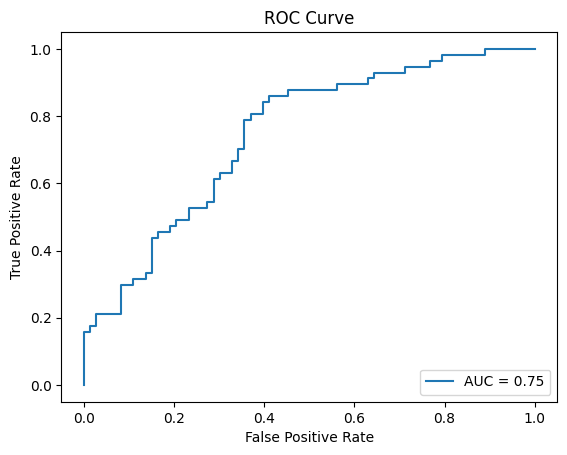

Epoch  75
Epoch: [75]/(10/26), Train Loss: 0.1979, Average Train Accuracy: 0.76, Average Train Precision: 0.73, Average Train Recall: 0.89, Average Train F1 Score: 0.78, Time: 21.83 sec
Epoch: [75]/(20/26), Train Loss: 0.2771, Average Train Accuracy: 0.78, Average Train Precision: 0.71, Average Train Recall: 0.81, Average Train F1 Score: 0.73, Time: 44.86 sec
Testing
Epoch: [75], Test Loss: 0.6647, Average Test Accuracy: 0.63, Average Test Precision: 0.61, Average Test Recall: 0.51, Average Test F1 Score: 0.52, Time: 10.09 sec


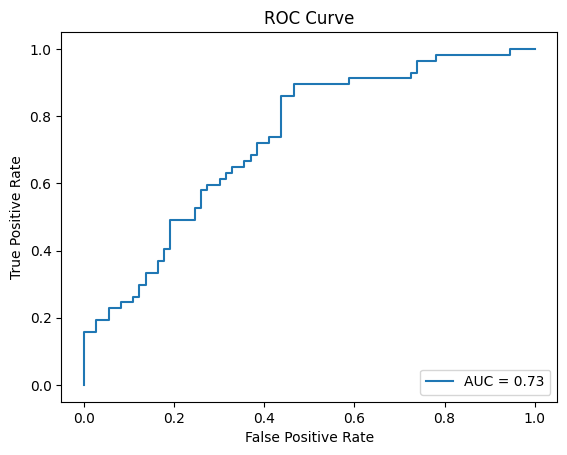

Epoch  76
Epoch: [76]/(10/26), Train Loss: 0.3817, Average Train Accuracy: 0.78, Average Train Precision: 0.70, Average Train Recall: 0.78, Average Train F1 Score: 0.72, Time: 22.89 sec
Epoch: [76]/(20/26), Train Loss: 0.2275, Average Train Accuracy: 0.79, Average Train Precision: 0.71, Average Train Recall: 0.75, Average Train F1 Score: 0.71, Time: 46.11 sec
Testing
Epoch: [76], Test Loss: 0.7076, Average Test Accuracy: 0.64, Average Test Precision: 0.64, Average Test Recall: 0.49, Average Test F1 Score: 0.51, Time: 10.29 sec


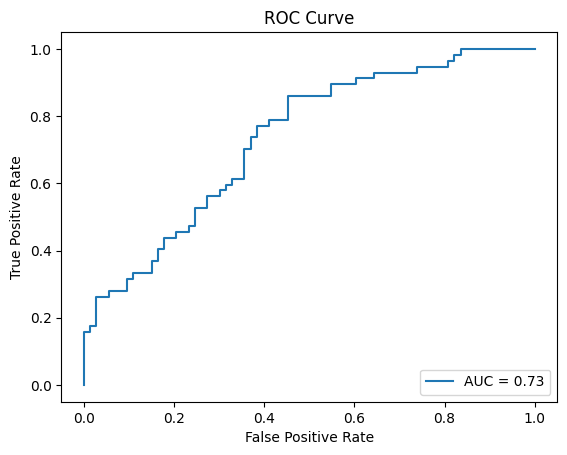

Epoch  77
Epoch: [77]/(10/26), Train Loss: 0.3849, Average Train Accuracy: 0.78, Average Train Precision: 0.70, Average Train Recall: 0.84, Average Train F1 Score: 0.72, Time: 22.64 sec
Epoch: [77]/(20/26), Train Loss: 0.4850, Average Train Accuracy: 0.78, Average Train Precision: 0.69, Average Train Recall: 0.76, Average Train F1 Score: 0.68, Time: 44.21 sec
Testing
Epoch: [77], Test Loss: 0.7982, Average Test Accuracy: 0.66, Average Test Precision: 0.65, Average Test Recall: 0.66, Average Test F1 Score: 0.60, Time: 10.17 sec


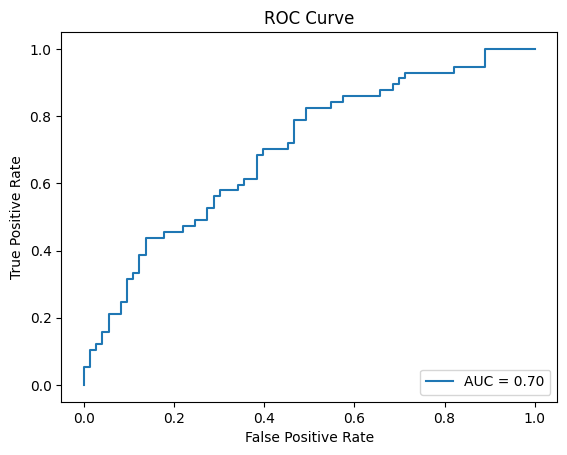

Epoch  78
Epoch: [78]/(10/26), Train Loss: 0.2576, Average Train Accuracy: 0.82, Average Train Precision: 0.76, Average Train Recall: 0.81, Average Train F1 Score: 0.77, Time: 21.22 sec
Epoch: [78]/(20/26), Train Loss: 0.3453, Average Train Accuracy: 0.82, Average Train Precision: 0.76, Average Train Recall: 0.79, Average Train F1 Score: 0.77, Time: 44.55 sec
Testing
Epoch: [78], Test Loss: 0.7419, Average Test Accuracy: 0.67, Average Test Precision: 0.60, Average Test Recall: 0.77, Average Test F1 Score: 0.66, Time: 9.23 sec


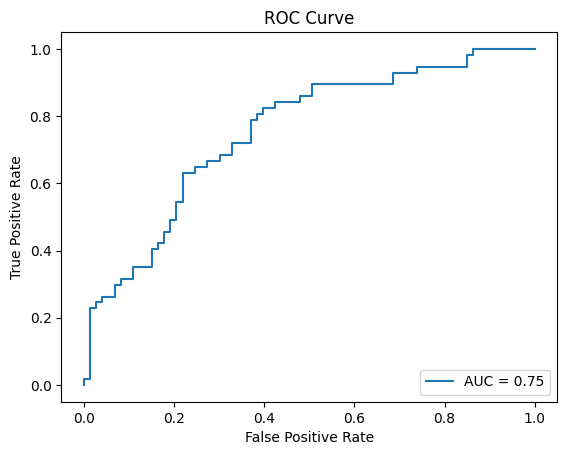

Epoch  79
Epoch: [79]/(10/26), Train Loss: 0.4691, Average Train Accuracy: 0.85, Average Train Precision: 0.73, Average Train Recall: 0.99, Average Train F1 Score: 0.83, Time: 23.59 sec
Epoch: [79]/(20/26), Train Loss: 0.3922, Average Train Accuracy: 0.83, Average Train Precision: 0.77, Average Train Recall: 0.85, Average Train F1 Score: 0.78, Time: 46.71 sec
Testing
Epoch: [79], Test Loss: 0.6013, Average Test Accuracy: 0.65, Average Test Precision: 0.58, Average Test Recall: 0.58, Average Test F1 Score: 0.56, Time: 9.38 sec


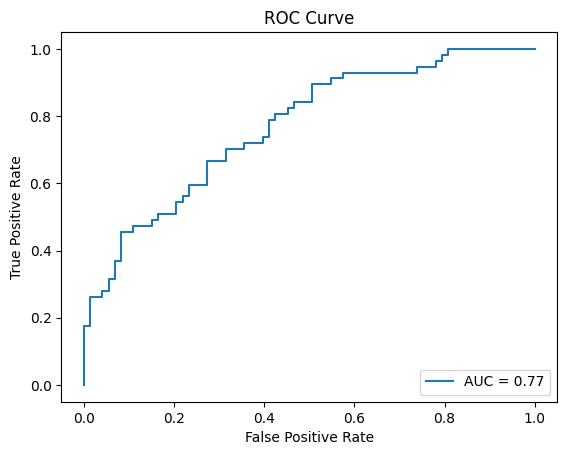

Epoch  80
Epoch: [80]/(10/26), Train Loss: 0.3837, Average Train Accuracy: 0.83, Average Train Precision: 0.79, Average Train Recall: 0.87, Average Train F1 Score: 0.80, Time: 24.12 sec


In [ ]:
train_loss = []
test_loss = []

best_acc = 0
best_precision = 0
best_recall = 0
best_f1_score = 0
f = open("./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/olcum_degerleri.txt", "a")

for epoch in range(1, 501):
    print ('Epoch ', epoch)
    train_loss.append(Train(epoch))
    test_loss.append(Test(epoch))

    if epoch % 10 == 0:
        fname = './drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_'+str(epoch)+'.pth'
        print(fname)
        torch.save(model, fname)

f.close()
print ('DONE')
